In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [ ]:
##mount drive
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],
                         std=[0.5,0.5,0.5])
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


Model definition and training

In [ ]:
##MOdel definnitions moved below

In [ ]:
device = "cuda"
z_dim = 64 ## randomly pciked
vae_list = [VAE(z_dim).to(device) , torch.optim.Adam(vae.parameters() , lr = 2e-4 , betas = (0.9 , 0.999) ) for i in range(5)]
epochs = 200
e_L, r_L, k_L = [],[],[]
beta = 0

In [ ]:
vae_lol = VAE(z_dim).to(device)
epochs = 50
beta = 0.6

In [ ]:
import torch
import torchvision
from tqdm import tqdm

device = "cuda"
epochs = 60
beta = 0.6  # fixed beta for this VAE

optimizer = torch.optim.Adam(vae_lol.parameters(), lr=2e-4, betas=(0.9, 0.999))

# --- History container ---
loss_hist = {
    "train_total": [], "train_recon": [], "train_kl": [],
    "test_total": [], "test_recon": [], "test_kl": []
}

for epoch in range(epochs):
    # --- Training ---
    vae_lol.train()
    e_loss, r_loss, kl_loss = 0.0, 0.0, 0.0
    n_train = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}] β={beta:.4f}", leave=False)
    for images, _ in loop:
        images = images.to(device)
        n_train += images.size(0)

        optimizer.zero_grad()
        recon_images, mu, log_var = vae_lol(images)
        losse, lossr, lossk = elbo(images, recon_images, mu, log_var, beta)

        losse.backward()
        optimizer.step()

        e_loss += losse.item() * images.size(0)
        r_loss += lossr.item() * images.size(0)
        kl_loss += lossk.item() * images.size(0)

        loop.set_postfix(
            total=f"{e_loss/n_train:.4f}",
            recon=f"{r_loss/n_train:.4f}",
            kl=f"{kl_loss/n_train:.4f}"
        )

    # store epoch averages
    loss_hist["train_total"].append(e_loss / n_train)
    loss_hist["train_recon"].append(r_loss / n_train)
    loss_hist["train_kl"].append(kl_loss / n_train)

    # --- Validation / Test ---
    vae_lol.eval()
    test_total, test_recon, test_kl = 0.0, 0.0, 0.0
    n_test = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            n_test += images.size(0)

            recon, mu, log_var = vae_lol(images)
            losse, lossr, lossk = elbo(images, recon, mu, log_var, beta)

            test_total += losse.item() * images.size(0)
            test_recon += lossr.item() * images.size(0)
            test_kl += lossk.item() * images.size(0)

    # store averages
    loss_hist["test_total"].append(test_total / n_test)
    loss_hist["test_recon"].append(test_recon / n_test)
    loss_hist["test_kl"].append(test_kl / n_test)

    print(f"[Epoch {epoch+1}/{epochs}] β={beta:.4f} "
          f"Train T={loss_hist['train_total'][-1]:.4f} "
          f"R={loss_hist['train_recon'][-1]:.4f} "
          f"KL={loss_hist['train_kl'][-1]:.4f} | "
          f"Test T={loss_hist['test_total'][-1]:.4f} "
          f"R={loss_hist['test_recon'][-1]:.4f} "
          f"KL={loss_hist['test_kl'][-1]:.4f}")

    # --- Reconstructions every 10 epochs (input + recon only) ---
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            sample_imgs = images[:8].to(device)
            recon_imgs, _, _ = vae_lol(sample_imgs)

            # Move to CPU
            sample_imgs = sample_imgs.cpu()
            recon_imgs = recon_imgs.cpu()

            # Combine input + reconstruction
            combined = torch.cat([sample_imgs, recon_imgs], dim=0)
            grid = torchvision.utils.make_grid(combined, nrow=8, normalize=True, scale_each=True)
            torchvision.utils.save_image(grid, f"vae_lol_recon_epoch{epoch+1}.png")


Epoch [1/60] β=0.6000:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 1/60] β=0.6000 Train T=0.2070 R=0.1807 KL=0.0438 | Test T=0.1889 R=0.1566 KL=0.0539


[Epoch 2/60] β=0.6000 Train T=0.1824 R=0.1513 KL=0.0519 | Test T=0.1772 R=0.1459 KL=0.0522


[Epoch 3/60] β=0.6000 Train T=0.1771 R=0.1453 KL=0.0530 | Test T=0.1752 R=0.1427 KL=0.0542


[Epoch 4/60] β=0.6000 Train T=0.1756 R=0.1437 KL=0.0531 | Test T=0.1737 R=0.1413 KL=0.0541


[Epoch 5/60] β=0.6000 Train T=0.1747 R=0.1423 KL=0.0539 | Test T=0.1731 R=0.1409 KL=0.0537


[Epoch 6/60] β=0.6000 Train T=0.1739 R=0.1412 KL=0.0545 | Test T=0.1721 R=0.1404 KL=0.0529


[Epoch 7/60] β=0.6000 Train T=0.1733 R=0.1402 KL=0.0553 | Test T=0.1717 R=0.1380 KL=0.0561


[Epoch 8/60] β=0.6000 Train T=0.1728 R=0.1386 KL=0.0570 | Test T=0.1707 R=0.1349 KL=0.0596


[Epoch 9/60] β=0.6000 Train T=0.1722 R=0.1374 KL=0.0580 | Test T=0.1710 R=0.1359 KL=0.0585


[Epoch 10/60] β=0.6000 Train T=0.1717 R=0.1367 KL=0.0584 | Test T=0.1704 R=0.1355 KL=0.0582


[Epoch 11/60] β=0.6000 Train T=0.1718 R=0.1366 KL=0.0586 | Test T=0.1696 R=0.1350 KL=0.0577


[Epoch 12/60] β=0.6000 Train T=0.1714 R=0.1361 KL=0.0588 | Test T=0.1697 R=0.1352 KL=0.0575


[Epoch 13/60] β=0.6000 Train T=0.1710 R=0.1355 KL=0.0591 | Test T=0.1694 R=0.1347 KL=0.0577


[Epoch 14/60] β=0.6000 Train T=0.1711 R=0.1354 KL=0.0595 | Test T=0.1689 R=0.1331 KL=0.0598


[Epoch 15/60] β=0.6000 Train T=0.1707 R=0.1349 KL=0.0598 | Test T=0.1694 R=0.1327 KL=0.0613


[Epoch 16/60] β=0.6000 Train T=0.1708 R=0.1347 KL=0.0601 | Test T=0.1691 R=0.1330 KL=0.0601


[Epoch 17/60] β=0.6000 Train T=0.1704 R=0.1342 KL=0.0603 | Test T=0.1692 R=0.1322 KL=0.0616


[Epoch 18/60] β=0.6000 Train T=0.1702 R=0.1340 KL=0.0603 | Test T=0.1693 R=0.1318 KL=0.0625


[Epoch 19/60] β=0.6000 Train T=0.1702 R=0.1339 KL=0.0605 | Test T=0.1688 R=0.1320 KL=0.0613


[Epoch 20/60] β=0.6000 Train T=0.1701 R=0.1337 KL=0.0607 | Test T=0.1684 R=0.1317 KL=0.0612


[Epoch 21/60] β=0.6000 Train T=0.1702 R=0.1336 KL=0.0610 | Test T=0.1689 R=0.1321 KL=0.0612


[Epoch 22/60] β=0.6000 Train T=0.1701 R=0.1332 KL=0.0615 | Test T=0.1686 R=0.1319 KL=0.0612


[Epoch 23/60] β=0.6000 Train T=0.1698 R=0.1330 KL=0.0613 | Test T=0.1681 R=0.1314 KL=0.0613


[Epoch 24/60] β=0.6000 Train T=0.1697 R=0.1326 KL=0.0618 | Test T=0.1682 R=0.1319 KL=0.0605


[Epoch 25/60] β=0.6000 Train T=0.1696 R=0.1324 KL=0.0620 | Test T=0.1680 R=0.1311 KL=0.0616


[Epoch 26/60] β=0.6000 Train T=0.1694 R=0.1320 KL=0.0624 | Test T=0.1678 R=0.1310 KL=0.0613


[Epoch 27/60] β=0.6000 Train T=0.1693 R=0.1318 KL=0.0625 | Test T=0.1682 R=0.1318 KL=0.0607


[Epoch 28/60] β=0.6000 Train T=0.1694 R=0.1319 KL=0.0626 | Test T=0.1677 R=0.1303 KL=0.0624


KeyboardInterrupt: 

In [ ]:
import torch
import torchvision
from tqdm import tqdm

device = "cuda"
z_dim = 64
epochs = 60

# fixed betas for models 1–4
fixed_betas = [0.0, 0.001, 0.01, 0.1]

# --- Initialize models + optimizers ---
vae_list = []
for _ in range(5):
    vae = VAE(z_dim).to(device)
    optimV = torch.optim.Adam(vae.parameters(), lr=2e-4, betas=(0.9, 0.999))
    vae_list.append((vae, optimV))

# --- History container for each model ---
loss_hist = {
    i: {
        "train_total": [], "train_recon": [], "train_kl": [],
        "test_total": [], "test_recon": [], "test_kl": []
    }
    for i in range(len(vae_list))
}

# --- Training loop ---
for epoch in range(epochs):
    for model_idx, (vae, optimV) in enumerate(vae_list):

        # --- select beta ---
        if model_idx < 4:
            beta = fixed_betas[model_idx]
        else:
            beta = 0.1 * (epoch / (epochs - 1))  # annealed 0 → 0.1

        # --- Training ---
        vae.train()
        e_loss, r_loss, kl_loss = 0.0, 0.0, 0.0
        n_train = 0

        loop = tqdm(train_loader, desc=f"VAE#{model_idx+1} Epoch [{epoch+1}/{epochs}] β={beta:.4f}", leave=False)
        for images, _ in loop:
            images = images.to(device)
            n_train += images.size(0)

            optimV.zero_grad()
            recon_images, mu, log_var = vae(images)
            losse, lossr, lossk = elbo(images, recon_images, mu, log_var, beta)

            losse.backward()
            optimV.step()

            e_loss += losse.item() * images.size(0)
            r_loss += lossr.item() * images.size(0)
            kl_loss += lossk.item() * images.size(0)

            loop.set_postfix(
                total=f"{e_loss/n_train:.4f}",
                recon=f"{r_loss/n_train:.4f}",
                kl=f"{kl_loss/n_train:.4f}"
            )

        # store epoch averages
        loss_hist[model_idx]["train_total"].append(e_loss / n_train)
        loss_hist[model_idx]["train_recon"].append(r_loss / n_train)
        loss_hist[model_idx]["train_kl"].append(kl_loss / n_train)

        # --- Validation / Test ---
        vae.eval()
        test_total, test_recon, test_kl = 0.0, 0.0, 0.0
        n_test = 0
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                n_test += images.size(0)

                recon, mu, log_var = vae(images)
                losse, lossr, lossk = elbo(images, recon, mu, log_var, beta)

                test_total += losse.item() * images.size(0)
                test_recon += lossr.item() * images.size(0)
                test_kl += lossk.item() * images.size(0)

        # store averages
        loss_hist[model_idx]["test_total"].append(test_total / n_test)
        loss_hist[model_idx]["test_recon"].append(test_recon / n_test)
        loss_hist[model_idx]["test_kl"].append(test_kl / n_test)

        print(f"[Epoch {epoch+1}/{epochs}] VAE#{model_idx+1} β={beta:.4f} "
              f"Train T={loss_hist[model_idx]['train_total'][-1]:.4f} "
              f"R={loss_hist[model_idx]['train_recon'][-1]:.4f} "
              f"KL={loss_hist[model_idx]['train_kl'][-1]:.4f} | "
              f"Test T={loss_hist[model_idx]['test_total'][-1]:.4f} "
              f"R={loss_hist[model_idx]['test_recon'][-1]:.4f} "
              f"KL={loss_hist[model_idx]['test_kl'][-1]:.4f}")

        # --- Reconstructions every 10 epochs ---
        if (epoch + 1) % 10 == 0:
            with torch.no_grad():
                sample_imgs = images[:8].cpu()
                recon_imgs, _, _ = vae(sample_imgs.to(device))
                gen_imgs = vae.decoder(torch.randn(8, z_dim).to(device)).cpu()

                combined = torch.cat([sample_imgs, recon_imgs.cpu(), gen_imgs], dim=0)
                grid = torchvision.utils.make_grid(combined, nrow=8, normalize=True, scale_each=True)
                torchvision.utils.save_image(grid, f"vae{model_idx+1}_epoch{epoch+1}.png")


[Epoch 1/60] VAE#1 β=0.0000 Train T=0.1229 R=0.1229 KL=9.5236 | Test T=0.0802 R=0.0802 KL=10.0217


[Epoch 1/60] VAE#2 β=0.0010 Train T=0.1272 R=0.1248 KL=2.3560 | Test T=0.0762 R=0.0735 KL=2.6811


[Epoch 1/60] VAE#3 β=0.0100 Train T=0.1449 R=0.1380 KL=0.6947 | Test T=0.0992 R=0.0900 KL=0.9283


[Epoch 1/60] VAE#4 β=0.1000 Train T=0.1793 R=0.1651 KL=0.1416 | Test T=0.1398 R=0.1200 KL=0.1987


[Epoch 1/60] VAE#5 β=0.0000 Train T=0.1200 R=0.1200 KL=10.7075 | Test T=0.0787 R=0.0787 KL=11.1798


[Epoch 2/60] VAE#1 β=0.0000 Train T=0.0665 R=0.0665 KL=11.5421 | Test T=0.0578 R=0.0578 KL=11.8132


[Epoch 2/60] VAE#2 β=0.0010 Train T=0.0694 R=0.0666 KL=2.7375 | Test T=0.0621 R=0.0593 KL=2.8023


[Epoch 2/60] VAE#3 β=0.0100 Train T=0.0935 R=0.0836 KL=0.9925 | Test T=0.0883 R=0.0779 KL=1.0364


[Epoch 2/60] VAE#4 β=0.1000 Train T=0.1335 R=0.1123 KL=0.2119 | Test T=0.1279 R=0.1060 KL=0.2193


[Epoch 2/60] VAE#5 β=0.0017 Train T=0.0755 R=0.0704 KL=2.9899 | Test T=0.0655 R=0.0613 KL=2.5006


[Epoch 3/60] VAE#1 β=0.0000 Train T=0.0546 R=0.0546 KL=12.3101 | Test T=0.0514 R=0.0514 KL=12.8278


[Epoch 3/60] VAE#2 β=0.0010 Train T=0.0587 R=0.0559 KL=2.8096 | Test T=0.0550 R=0.0521 KL=2.8166


[Epoch 3/60] VAE#3 β=0.0100 Train T=0.0817 R=0.0707 KL=1.1035 | Test T=0.0748 R=0.0634 KL=1.1445


[Epoch 3/60] VAE#4 β=0.1000 Train T=0.1251 R=0.1032 KL=0.2191 | Test T=0.1225 R=0.1004 KL=0.2209


[Epoch 3/60] VAE#5 β=0.0034 Train T=0.0655 R=0.0586 KL=2.0390 | Test T=0.0619 R=0.0550 KL=2.0430


[Epoch 4/60] VAE#1 β=0.0000 Train T=0.0489 R=0.0489 KL=13.1929 | Test T=0.0466 R=0.0466 KL=13.2987


[Epoch 4/60] VAE#2 β=0.0010 Train T=0.0533 R=0.0504 KL=2.8409 | Test T=0.0504 R=0.0475 KL=2.8641


[Epoch 4/60] VAE#3 β=0.0100 Train T=0.0726 R=0.0610 KL=1.1593 | Test T=0.0697 R=0.0581 KL=1.1564


[Epoch 4/60] VAE#4 β=0.1000 Train T=0.1214 R=0.0987 KL=0.2271 | Test T=0.1196 R=0.0968 KL=0.2288


[Epoch 4/60] VAE#5 β=0.0051 Train T=0.0632 R=0.0541 KL=1.7780 | Test T=0.0621 R=0.0532 KL=1.7525


[Epoch 5/60] VAE#1 β=0.0000 Train T=0.0456 R=0.0456 KL=13.9405 | Test T=0.0440 R=0.0440 KL=13.9473


[Epoch 5/60] VAE#2 β=0.0010 Train T=0.0502 R=0.0473 KL=2.8485 | Test T=0.0480 R=0.0452 KL=2.8378


[Epoch 5/60] VAE#3 β=0.0100 Train T=0.0685 R=0.0568 KL=1.1751 | Test T=0.0668 R=0.0551 KL=1.1728


[Epoch 5/60] VAE#4 β=0.1000 Train T=0.1172 R=0.0929 KL=0.2428 | Test T=0.1144 R=0.0895 KL=0.2494


[Epoch 5/60] VAE#5 β=0.0068 Train T=0.0626 R=0.0516 KL=1.6288 | Test T=0.0607 R=0.0500 KL=1.5850


[Epoch 6/60] VAE#1 β=0.0000 Train T=0.0428 R=0.0428 KL=14.7424 | Test T=0.0412 R=0.0412 KL=15.6732


[Epoch 6/60] VAE#2 β=0.0010 Train T=0.0475 R=0.0446 KL=2.8771 | Test T=0.0461 R=0.0432 KL=2.8677


[Epoch 6/60] VAE#3 β=0.0100 Train T=0.0655 R=0.0536 KL=1.1963 | Test T=0.0635 R=0.0514 KL=1.2063


[Epoch 6/60] VAE#4 β=0.1000 Train T=0.1138 R=0.0885 KL=0.2533 | Test T=0.1129 R=0.0880 KL=0.2488


[Epoch 6/60] VAE#5 β=0.0085 Train T=0.0630 R=0.0503 KL=1.5071 | Test T=0.0617 R=0.0493 KL=1.4658


[Epoch 7/60] VAE#1 β=0.0000 Train T=0.0407 R=0.0407 KL=15.4574 | Test T=0.0397 R=0.0397 KL=15.9398


[Epoch 7/60] VAE#2 β=0.0010 Train T=0.0455 R=0.0426 KL=2.9086 | Test T=0.0447 R=0.0418 KL=2.9166


[Epoch 7/60] VAE#3 β=0.0100 Train T=0.0632 R=0.0511 KL=1.2156 | Test T=0.0620 R=0.0497 KL=1.2251


[Epoch 7/60] VAE#4 β=0.1000 Train T=0.1121 R=0.0863 KL=0.2580 | Test T=0.1110 R=0.0850 KL=0.2597


[Epoch 7/60] VAE#5 β=0.0102 Train T=0.0637 R=0.0494 KL=1.4089 | Test T=0.0620 R=0.0480 KL=1.3842


[Epoch 8/60] VAE#1 β=0.0000 Train T=0.0391 R=0.0391 KL=16.0511 | Test T=0.0377 R=0.0377 KL=15.8562


[Epoch 8/60] VAE#2 β=0.0010 Train T=0.0439 R=0.0410 KL=2.9253 | Test T=0.0441 R=0.0412 KL=2.9043


[Epoch 8/60] VAE#3 β=0.0100 Train T=0.0616 R=0.0493 KL=1.2315 | Test T=0.0608 R=0.0486 KL=1.2207


[Epoch 8/60] VAE#4 β=0.1000 Train T=0.1107 R=0.0845 KL=0.2616 | Test T=0.1099 R=0.0836 KL=0.2635


[Epoch 8/60] VAE#5 β=0.0119 Train T=0.0644 R=0.0488 KL=1.3193 | Test T=0.0631 R=0.0473 KL=1.3284


[Epoch 9/60] VAE#1 β=0.0000 Train T=0.0380 R=0.0380 KL=16.0667 | Test T=0.0365 R=0.0365 KL=16.2845


[Epoch 9/60] VAE#2 β=0.0010 Train T=0.0425 R=0.0395 KL=2.9371 | Test T=0.0411 R=0.0382 KL=2.9575


[Epoch 9/60] VAE#3 β=0.0100 Train T=0.0604 R=0.0480 KL=1.2475 | Test T=0.0594 R=0.0471 KL=1.2329


[Epoch 9/60] VAE#4 β=0.1000 Train T=0.1097 R=0.0833 KL=0.2635 | Test T=0.1090 R=0.0826 KL=0.2634


[Epoch 9/60] VAE#5 β=0.0136 Train T=0.0651 R=0.0482 KL=1.2449 | Test T=0.0640 R=0.0474 KL=1.2268


[Epoch 10/60] VAE#1 β=0.0000 Train T=0.0369 R=0.0369 KL=16.3703 | Test T=0.0356 R=0.0356 KL=16.2454


[Epoch 10/60] VAE#2 β=0.0010 Train T=0.0413 R=0.0383 KL=2.9457 | Test T=0.0399 R=0.0369 KL=2.9587


[Epoch 10/60] VAE#3 β=0.0100 Train T=0.0596 R=0.0471 KL=1.2568 | Test T=0.0589 R=0.0465 KL=1.2413


[Epoch 10/60] VAE#4 β=0.1000 Train T=0.1089 R=0.0825 KL=0.2640 | Test T=0.1082 R=0.0817 KL=0.2647


[Epoch 10/60] VAE#5 β=0.0153 Train T=0.0660 R=0.0480 KL=1.1812 | Test T=0.0649 R=0.0468 KL=1.1858


[Epoch 11/60] VAE#1 β=0.0000 Train T=0.0360 R=0.0360 KL=16.5527 | Test T=0.0349 R=0.0349 KL=16.5155


[Epoch 11/60] VAE#2 β=0.0010 Train T=0.0404 R=0.0374 KL=2.9476 | Test T=0.0399 R=0.0369 KL=2.9549


[Epoch 11/60] VAE#3 β=0.0100 Train T=0.0588 R=0.0461 KL=1.2696 | Test T=0.0579 R=0.0450 KL=1.2887


[Epoch 11/60] VAE#4 β=0.1000 Train T=0.1084 R=0.0818 KL=0.2657 | Test T=0.1080 R=0.0815 KL=0.2648


[Epoch 11/60] VAE#5 β=0.0169 Train T=0.0670 R=0.0480 KL=1.1230 | Test T=0.0662 R=0.0473 KL=1.1153


[Epoch 12/60] VAE#1 β=0.0000 Train T=0.0354 R=0.0354 KL=16.5505 | Test T=0.0346 R=0.0346 KL=16.5089


[Epoch 12/60] VAE#2 β=0.0010 Train T=0.0396 R=0.0367 KL=2.9514 | Test T=0.0395 R=0.0365 KL=2.9655


[Epoch 12/60] VAE#3 β=0.0100 Train T=0.0580 R=0.0450 KL=1.2947 | Test T=0.0569 R=0.0439 KL=1.3041


[Epoch 12/60] VAE#4 β=0.1000 Train T=0.1080 R=0.0814 KL=0.2662 | Test T=0.1074 R=0.0810 KL=0.2633


[Epoch 12/60] VAE#5 β=0.0186 Train T=0.0682 R=0.0482 KL=1.0712 | Test T=0.0680 R=0.0479 KL=1.0758


[Epoch 13/60] VAE#1 β=0.0000 Train T=0.0349 R=0.0349 KL=16.7972 | Test T=0.0346 R=0.0346 KL=16.4352


[Epoch 13/60] VAE#2 β=0.0010 Train T=0.0391 R=0.0362 KL=2.9437 | Test T=0.0383 R=0.0354 KL=2.9013


[Epoch 13/60] VAE#3 β=0.0100 Train T=0.0572 R=0.0440 KL=1.3135 | Test T=0.0577 R=0.0445 KL=1.3161


[Epoch 13/60] VAE#4 β=0.1000 Train T=0.1075 R=0.0808 KL=0.2668 | Test T=0.1074 R=0.0803 KL=0.2716


[Epoch 13/60] VAE#5 β=0.0203 Train T=0.0692 R=0.0484 KL=1.0257 | Test T=0.0693 R=0.0489 KL=1.0061


[Epoch 14/60] VAE#1 β=0.0000 Train T=0.0348 R=0.0348 KL=16.4282 | Test T=0.0342 R=0.0342 KL=16.5814


[Epoch 14/60] VAE#2 β=0.0010 Train T=0.0388 R=0.0359 KL=2.9368 | Test T=0.0396 R=0.0367 KL=2.9240


[Epoch 14/60] VAE#3 β=0.0100 Train T=0.0566 R=0.0434 KL=1.3255 | Test T=0.0559 R=0.0425 KL=1.3387


[Epoch 14/60] VAE#4 β=0.1000 Train T=0.1071 R=0.0804 KL=0.2677 | Test T=0.1070 R=0.0798 KL=0.2721


[Epoch 14/60] VAE#5 β=0.0220 Train T=0.0704 R=0.0487 KL=0.9832 | Test T=0.0705 R=0.0491 KL=0.9741


[Epoch 15/60] VAE#1 β=0.0000 Train T=0.0347 R=0.0347 KL=16.4449 | Test T=0.0339 R=0.0339 KL=16.7568


[Epoch 15/60] VAE#2 β=0.0010 Train T=0.0385 R=0.0355 KL=2.9333 | Test T=0.0384 R=0.0355 KL=2.9040


[Epoch 15/60] VAE#3 β=0.0100 Train T=0.0562 R=0.0428 KL=1.3365 | Test T=0.0557 R=0.0423 KL=1.3385


[Epoch 15/60] VAE#4 β=0.1000 Train T=0.1069 R=0.0800 KL=0.2684 | Test T=0.1067 R=0.0794 KL=0.2724


[Epoch 15/60] VAE#5 β=0.0237 Train T=0.0717 R=0.0493 KL=0.9438 | Test T=0.0710 R=0.0487 KL=0.9384


[Epoch 16/60] VAE#1 β=0.0000 Train T=0.0345 R=0.0345 KL=16.7125 | Test T=0.0337 R=0.0337 KL=16.8550


[Epoch 16/60] VAE#2 β=0.0010 Train T=0.0382 R=0.0353 KL=2.9241 | Test T=0.0384 R=0.0355 KL=2.9244


[Epoch 16/60] VAE#3 β=0.0100 Train T=0.0558 R=0.0424 KL=1.3461 | Test T=0.0550 R=0.0414 KL=1.3519


[Epoch 16/60] VAE#4 β=0.1000 Train T=0.1065 R=0.0796 KL=0.2687 | Test T=0.1064 R=0.0796 KL=0.2677


[Epoch 16/60] VAE#5 β=0.0254 Train T=0.0729 R=0.0499 KL=0.9072 | Test T=0.0722 R=0.0489 KL=0.9179


[Epoch 17/60] VAE#1 β=0.0000 Train T=0.0343 R=0.0343 KL=16.8091 | Test T=0.0341 R=0.0341 KL=17.2016


[Epoch 17/60] VAE#2 β=0.0010 Train T=0.0381 R=0.0352 KL=2.9183 | Test T=0.0383 R=0.0354 KL=2.9249


[Epoch 17/60] VAE#3 β=0.0100 Train T=0.0555 R=0.0419 KL=1.3555 | Test T=0.0551 R=0.0417 KL=1.3402


[Epoch 17/60] VAE#4 β=0.1000 Train T=0.1063 R=0.0793 KL=0.2696 | Test T=0.1063 R=0.0790 KL=0.2727


[Epoch 17/60] VAE#5 β=0.0271 Train T=0.0741 R=0.0505 KL=0.8727 | Test T=0.0735 R=0.0502 KL=0.8583


[Epoch 18/60] VAE#1 β=0.0000 Train T=0.0342 R=0.0342 KL=16.9083 | Test T=0.0339 R=0.0339 KL=16.9536


[Epoch 18/60] VAE#2 β=0.0010 Train T=0.0379 R=0.0350 KL=2.9144 | Test T=0.0372 R=0.0343 KL=2.8830


[Epoch 18/60] VAE#3 β=0.0100 Train T=0.0551 R=0.0415 KL=1.3665 | Test T=0.0547 R=0.0409 KL=1.3781


[Epoch 18/60] VAE#4 β=0.1000 Train T=0.1060 R=0.0789 KL=0.2708 | Test T=0.1063 R=0.0797 KL=0.2661


[Epoch 18/60] VAE#5 β=0.0288 Train T=0.0753 R=0.0511 KL=0.8402 | Test T=0.0748 R=0.0507 KL=0.8349


[Epoch 19/60] VAE#1 β=0.0000 Train T=0.0341 R=0.0341 KL=16.9575 | Test T=0.0339 R=0.0339 KL=17.3079


[Epoch 19/60] VAE#2 β=0.0010 Train T=0.0378 R=0.0349 KL=2.9009 | Test T=0.0373 R=0.0344 KL=2.8367


[Epoch 19/60] VAE#3 β=0.0100 Train T=0.0550 R=0.0413 KL=1.3692 | Test T=0.0544 R=0.0408 KL=1.3585


[Epoch 19/60] VAE#4 β=0.1000 Train T=0.1058 R=0.0787 KL=0.2714 | Test T=0.1056 R=0.0785 KL=0.2715


[Epoch 19/60] VAE#5 β=0.0305 Train T=0.0765 R=0.0517 KL=0.8110 | Test T=0.0759 R=0.0517 KL=0.7940


[Epoch 20/60] VAE#1 β=0.0000 Train T=0.0340 R=0.0340 KL=17.0612 | Test T=0.0336 R=0.0336 KL=17.0169


[Epoch 20/60] VAE#2 β=0.0010 Train T=0.0377 R=0.0348 KL=2.8984 | Test T=0.0373 R=0.0344 KL=2.8793


[Epoch 20/60] VAE#3 β=0.0100 Train T=0.0546 R=0.0408 KL=1.3767 | Test T=0.0545 R=0.0407 KL=1.3769


[Epoch 20/60] VAE#4 β=0.1000 Train T=0.1056 R=0.0784 KL=0.2720 | Test T=0.1056 R=0.0785 KL=0.2709


[Epoch 20/60] VAE#5 β=0.0322 Train T=0.0776 R=0.0525 KL=0.7799 | Test T=0.0780 R=0.0530 KL=0.7756


[Epoch 21/60] VAE#1 β=0.0000 Train T=0.0339 R=0.0339 KL=16.8918 | Test T=0.0339 R=0.0339 KL=16.8435


[Epoch 21/60] VAE#2 β=0.0010 Train T=0.0375 R=0.0347 KL=2.8946 | Test T=0.0379 R=0.0350 KL=2.8962


[Epoch 21/60] VAE#3 β=0.0100 Train T=0.0545 R=0.0406 KL=1.3822 | Test T=0.0539 R=0.0400 KL=1.3949


[Epoch 21/60] VAE#4 β=0.1000 Train T=0.1055 R=0.0782 KL=0.2724 | Test T=0.1056 R=0.0781 KL=0.2756


[Epoch 21/60] VAE#5 β=0.0339 Train T=0.0786 R=0.0531 KL=0.7533 | Test T=0.0786 R=0.0530 KL=0.7553


[Epoch 22/60] VAE#1 β=0.0000 Train T=0.0338 R=0.0338 KL=17.0095 | Test T=0.0339 R=0.0339 KL=17.0835


[Epoch 22/60] VAE#2 β=0.0010 Train T=0.0375 R=0.0346 KL=2.8878 | Test T=0.0371 R=0.0342 KL=2.8762


[Epoch 22/60] VAE#3 β=0.0100 Train T=0.0543 R=0.0405 KL=1.3859 | Test T=0.0541 R=0.0403 KL=1.3868


[Epoch 22/60] VAE#4 β=0.1000 Train T=0.1053 R=0.0780 KL=0.2730 | Test T=0.1052 R=0.0778 KL=0.2744


[Epoch 22/60] VAE#5 β=0.0356 Train T=0.0798 R=0.0539 KL=0.7275 | Test T=0.0800 R=0.0543 KL=0.7229


[Epoch 23/60] VAE#1 β=0.0000 Train T=0.0338 R=0.0338 KL=17.0891 | Test T=0.0335 R=0.0335 KL=16.7879


[Epoch 23/60] VAE#2 β=0.0010 Train T=0.0374 R=0.0345 KL=2.8833 | Test T=0.0373 R=0.0344 KL=2.8816


[Epoch 23/60] VAE#3 β=0.0100 Train T=0.0541 R=0.0403 KL=1.3890 | Test T=0.0534 R=0.0395 KL=1.3891


[Epoch 23/60] VAE#4 β=0.1000 Train T=0.1052 R=0.0778 KL=0.2741 | Test T=0.1051 R=0.0777 KL=0.2740


[Epoch 23/60] VAE#5 β=0.0373 Train T=0.0807 R=0.0545 KL=0.7023 | Test T=0.0805 R=0.0544 KL=0.7002


[Epoch 24/60] VAE#1 β=0.0000 Train T=0.0337 R=0.0337 KL=17.1972 | Test T=0.0333 R=0.0333 KL=17.2251


KeyboardInterrupt: 

Reconstruction Vs Generation

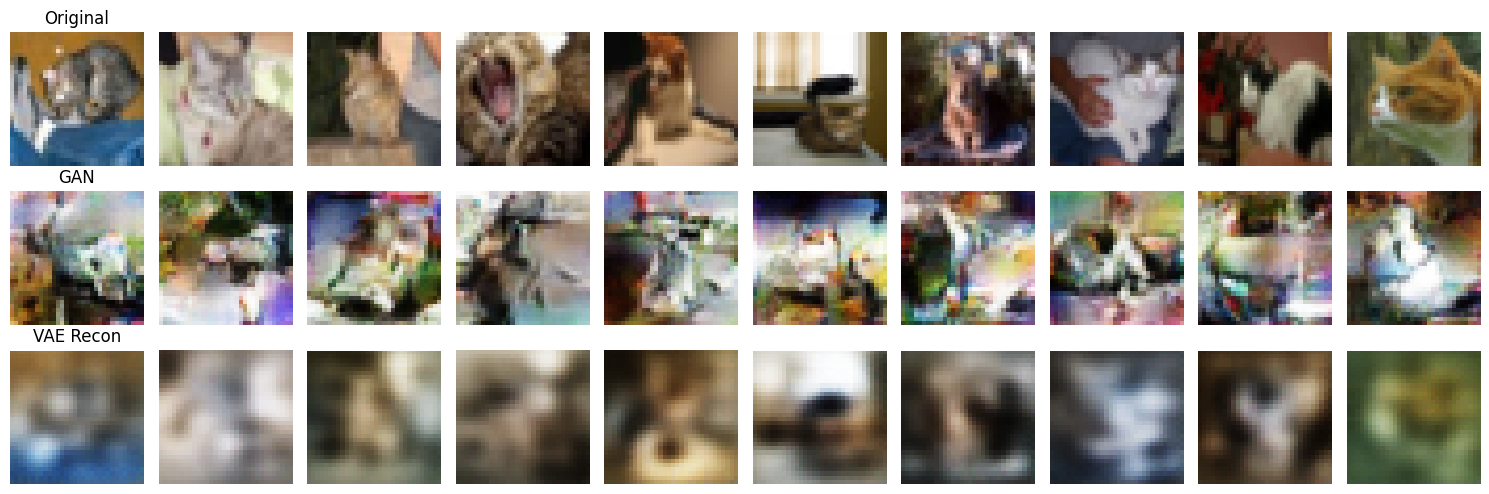

In [ ]:
import torch
import matplotlib.pyplot as plt

z_in = torch.randn(1000, z_dim).to(device)

# --- Collect 10 real images of class 4 ---
real_images = []
for x, y in test_loader:
    for i in range(len(y)):
        if y[i].item() == 3:
            real_images.append(x[i].unsqueeze(0))  # keep batch dim
            if len(real_images) == 10:
                break
    if len(real_images) == 10:
        break
real_images = torch.cat(real_images).to(device)

# --- Collect 10 GAN images classified as 4 ---
gan_images = []
with torch.no_grad():
    for z in z_in:
        fake = gen(z.unsqueeze(0))          # generate one image
        out = classifier1(fake)             # classify
        pred = torch.argmax(out, dim=1).item()
        if pred == 3:
            gan_images.append(fake)
            if len(gan_images) == 10:
                break
gan_images = torch.cat(gan_images)

# --- VAE reconstructions of the real images ---
with torch.no_grad():
    recon, mu, logvar = vae(real_images)

# --- Plot side by side ---
fig, axes = plt.subplots(3, 10, figsize=(15, 5))

for i in range(10):
    # Original
    axes[0, i].imshow(real_images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_title("Original")

    # GAN
    axes[1, i].imshow(gan_images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_title("GAN")

    # VAE Recon
    axes[2, i].imshow(recon[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    axes[2, i].axis("off")
    if i == 0:
        axes[2, i].set_title("VAE Recon")

plt.tight_layout()
plt.show()


In [ ]:
##In this case the GAN was trained far longer than the vae, whereas the vae still has an incomplete latent , hence the class imbalance by the vae

In [ ]:
##The resultant vae and GAN seems to be performing extremely similarly, with both having a wide range of diversity, however , the GAN has a greater variance, matching with the inherent instability

TESTING PHASE

In [ ]:
class VAE_b(nn.Module):## used for small betas
    def __init__(self, z_dim):
        super(VAE_b, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Flatten()
        )

        self.mu = nn.Sequential(
            nn.Linear(64 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, z_dim)
        )

        self.log_var = nn.Sequential(
            nn.Linear(64 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, z_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # output range [-1,1] for normalized input
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x):
        features = self.encoder(x)
        mu = self.mu(features)
        log_var = self.log_var(features)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var

In [ ]:
import torch.nn.functional as F

def elbo(x, x_recon, mu, log_var,beta):
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(x_recon, x, reduction='mean')  # averaged over batch & pixels
    kl_div = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())  # average over batch


    # ELBO = Reconstruction loss + KL divergence
    # Minimizing negative ELBO is equivalent to minimizing this loss
    return recon_loss + beta * kl_div,recon_loss,kl_div
device = "cuda"
z_dim = 64

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()

        # ----------- Encoder -----------
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),   # 32x32 -> 16x16
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 8x8 -> 4x4
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

        # ----------- Decoder -----------
        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # 8x8 -> 16x16
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # 16x16 -> 32x32
            nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc_decode(z))
        h = h.view(-1, 128, 4, 4)
        x_recon = self.decoder(h)
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
##GAN

class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(z_dim, 512 * 4 * 4)  # latent → 4x4 feature map

        self.net = nn.Sequential(
            # 4x4 → 8x8
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # 8x8 → 16x16
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # 16x16 → 32x32
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Final output layer
            nn.ConvTranspose2d(64, 3, 3, stride=1, padding=1),  # (3, 32, 32)
            nn.Tanh()
        )

    def forward(self, z):
        out = self.fc(z)                     # (B, z_dim) → (B, 512*4*4)
        out = out.view(-1, 512, 4, 4)        # (B, 512, 4, 4)
        img = self.net(out)                  # (B, 3, 32, 32)
        return img
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # 32x32 → 16x16
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # 16x16 → 8x8
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # 8x8 → 4x4
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # 4x4 → 1x1
            nn.Conv2d(256, 1, 4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1, 1)  # (B, 1)
class classifier(nn.Module):
    def __init__(self):
        super(classifier,self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 4, stride=2, padding=1)   # -> [B, 10, 16, 16]
        self.conv2 = nn.Conv2d(10, 15, 4, stride=2, padding=1)  # -> [B, 15, 8, 8]
        self.fc1 = nn.Linear(15 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 100)
        self.fc3 = nn.Linear(100, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))          # [B, 10, 16, 16]
        x = self.relu(self.conv2(x))          # [B, 15, 8, 8]
        x = x.view(x.size(0), -1)             # Flatten -> [B, 960]
        x = self.relu(self.fc1(x))            # [B, 256]
        x = self.relu(self.fc2(x))            # [B, 100]
        x = self.fc3(x)                       # [B, 10]
        return x

In [ ]:
import torch
z_dim = 64
device = "cuda"
# --- define models again ---
testing_vae = VAE(z_dim).to(device)
testing_gen = Generator(z_dim).to(device)
testing_dis = Discriminator().to(device)
classifier1 = classifier().to(device)
# --- load checkpoints (make sure paths are correct) ---
testing_vae.load_state_dict(torch.load("drive/MyDrive/Assignment_1/checkpoints/vae_final.pth"))
testing_gen.load_state_dict(torch.load("drive/MyDrive/Assignment_1/checkpoints/gener_weights.pth"))
testing_dis.load_state_dict(torch.load("drive/MyDrive/Assignment_1/checkpoints/discrim_weights (1).pth"))
classifier1.load_state_dict(torch.load("drive/MyDrive/Assignment_1/checkpoints/classifier (1).pth"))
# set to eval mode for inference
testing_vae.eval()
testing_gen.eval()
testing_dis.eval()
classifier1.eval()


classifier(
  (conv1): Conv2d(3, 10, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(10, 15, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=960, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
)

Test1: Reconstructions from the vae vs GAN generations

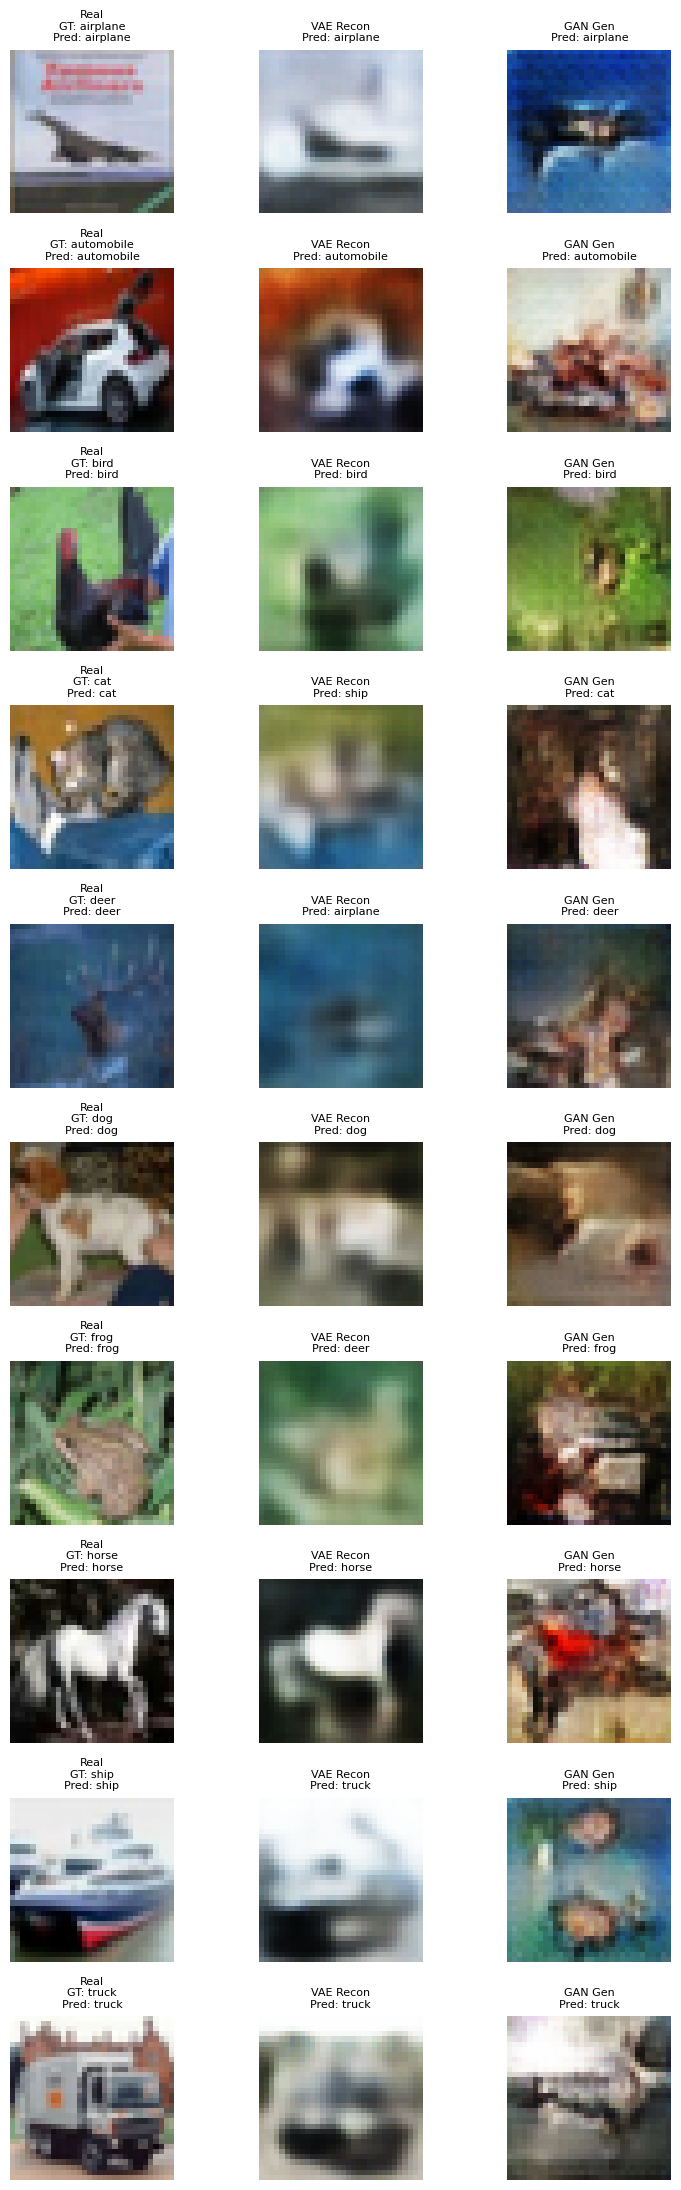

In [ ]:
import torch
import matplotlib.pyplot as plt

z_dim = 64
target_classes = list(range(10))  # CIFAR10 classes 0–9

gan_images = []
vae_recons = []
real_images = []

testing_vae.eval()
testing_gen.eval()
classifier1.eval()

with torch.no_grad():
    for target in target_classes:
        # --- get one real image of that class ---
        for img, lbl in test_loader:
            img, lbl = img.to(device), lbl.to(device)
            if (lbl == target).any():
                real_img = img[lbl == target][0:1]  # pick the first
                break

        # --- GAN: sample until classifier finds correct class ---
        found = False
        while not found:
            z = torch.randn(1, z_dim).to(device)
            fake = testing_gen(z)
            pred = classifier1(fake).argmax(dim=1).item()
            if pred == target:
                gan_img = fake
                found = True

        # --- VAE reconstruction ---
        recon, _, _ = testing_vae(real_img)

        # save for plotting
        real_images.append(real_img.cpu())
        gan_images.append(gan_img.cpu())
        vae_recons.append(recon.cpu())

# --- CIFAR10 labels ---
cifar_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# --- Plot side by side ---
fig, axes = plt.subplots(len(target_classes), 3, figsize=(8, len(target_classes) * 2.2))

for i, cls in enumerate(target_classes):
    # original
    axes[i, 0].imshow((real_images[i][0].permute(1, 2, 0) * 0.5 + 0.5).clamp(0, 1))
    pred_real = classifier1(real_images[i].to(device)).argmax(dim=1).item()
    axes[i, 0].set_title(f"Real\nGT: {cifar_labels[cls]}\nPred: {cifar_labels[pred_real]}", fontsize=8)
    axes[i, 0].axis("off")

    # VAE reconstruction
    pred_vae = classifier1(vae_recons[i].to(device)).argmax(dim=1).item()
    axes[i, 1].imshow((vae_recons[i][0].permute(1, 2, 0) * 0.5 + 0.5).clamp(0, 1))
    axes[i, 1].set_title(f"VAE Recon\nPred: {cifar_labels[pred_vae]}", fontsize=8)
    axes[i, 1].axis("off")

    # GAN sample
    pred_gan = classifier1(gan_images[i].to(device)).argmax(dim=1).item()
    axes[i, 2].imshow((gan_images[i][0].permute(1, 2, 0) * 0.5 + 0.5).clamp(0, 1))
    axes[i, 2].set_title(f"GAN Gen\nPred: {cifar_labels[pred_gan]}", fontsize=8)
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


Visuals:
Upon reconstrcuting and generating images from both classes, there is a remarkable difference in image quality, with GANS having sharper images with more varied colour distributions. This is due to the fact that the images are optimized on an adversarial pressure, with the generator focusing on adjusting generation features such that it can fool the discriminator rather than produce a generation resembling the original image
The VAEs however, displayed blurred reconstructions due to their loss being reconstruction based, hence, training instead focused on minimzing the difference between input and output images, leading to a blur due to the model averaging over subtle details e.g letters or patterns



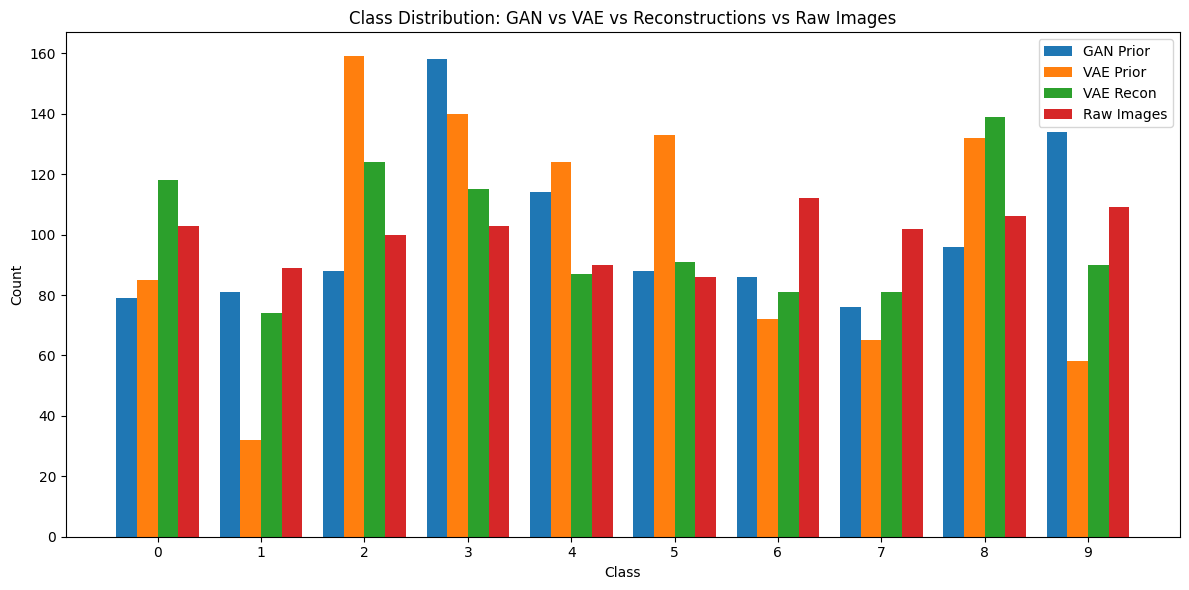

Inception Scores (using classifier1):
GAN Prior    : 7.476
VAE Prior    : 6.625
VAE Recon    : 8.191
Raw Images   : 9.888
Inception Scores (using classifier1):
GAN Prior    : 7.476
VAE Prior    : 6.625
VAE Recon    : 8.191
Raw Images   : 9.888

Class-wise average confidence per dataset:
Class | GAN Prior | VAE Prior | VAE Recon | Raw Images
-------------------------------------------------------
    0 |     0.897 |     0.857 |     0.933 |      0.997
    1 |     0.922 |     0.848 |     0.928 |      1.000
    2 |     0.877 |     0.878 |     0.926 |      0.999
    3 |     0.909 |     0.868 |     0.915 |      0.999
    4 |     0.896 |     0.871 |     0.923 |      0.999
    5 |     0.862 |     0.871 |     0.933 |      0.998
    6 |     0.901 |     0.852 |     0.924 |      0.998
    7 |     0.874 |     0.885 |     0.962 |      1.000
    8 |     0.911 |     0.895 |     0.940 |      0.997
    9 |     0.905 |     0.882 |     0.943 |      0.998


In [ ]:
# --- Inception Score using classifier1 ---
def compute_inception_score(model, images, batch_size=64, splits=1, device='cuda'):
    """
    Compute the Inception Score for a set of images using a custom classifier.

    Args:
        model (nn.Module): Custom classifier returning logits or softmax outputs.
        images (Tensor): Images of shape (N, C, H, W)
        batch_size (int): Batch size for prediction.
        splits (int): Number of splits (usually 1 for simplicity).
        device (str): Device to run on.

    Returns:
        float: Inception Score.
    """
    model.eval()
    preds = []

    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size].to(device)
            logits = model(batch)
            probs = torch.nn.functional.softmax(logits, dim=1)
            preds.append(probs.cpu())

    preds = torch.cat(preds, dim=0).numpy()  # shape: (N, num_classes)

    scores = []
    N = preds.shape[0]

    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0, keepdims=True)
        kl = part * (np.log(part + 1e-16) - np.log(py + 1e-16))
        kl_sum = np.sum(kl, axis=1)
        score = np.exp(np.mean(kl_sum))
        scores.append(score)

    return float(np.mean(scores))
# Convert lists of tensors to a single tensor if needed
import torch
import numpy as np
import matplotlib.pyplot as plt

n_samples = 1000

gan_images_list = []
vae_images_list = []
recon_images_list = []
raw_images_list = []

gan_preds = []
vae_preds = []
recon_preds = []
raw_preds = []

with torch.no_grad():
    # --- Sample GAN images ---
    z = torch.randn(n_samples, z_dim).to(device)
    gan_samples = testing_gen(z)  # (n_samples, C, H, W)
    gan_out = classifier1(gan_samples)
    gan_preds = gan_out.argmax(dim=1).cpu().numpy()
    gan_images_list.append(gan_samples.cpu())

    # --- Sample VAE prior images ---
    vae_samples = testing_vae.decode(z)  # (n_samples, C, H, W)
    vae_out = classifier1(vae_samples)
    vae_preds = vae_out.argmax(dim=1).cpu().numpy()
    vae_images_list.append(vae_samples.cpu())

    # --- Collect raw images and VAE reconstructions from test_loader ---
    count = 0
    for x, _ in test_loader:
        x = x.to(device)
        batch_size = x.shape[0]

        # Raw images
        raw_out = classifier1(x)
        raw_preds.extend(raw_out.argmax(dim=1).cpu().numpy())
        raw_images_list.append(x.cpu())

        # VAE reconstructions
        recon, _, _ = testing_vae(x)  # assuming forward returns (recon, mu, logvar)
        recon_out = classifier1(recon)
        recon_preds.extend(recon_out.argmax(dim=1).cpu().numpy())
        recon_images_list.append(recon.cpu())

        count += batch_size
        if count >= n_samples:
            break

# Concatenate lists into tensors and numpy arrays
gan_images = torch.cat(gan_images_list, dim=0)[:n_samples]
vae_images = torch.cat(vae_images_list, dim=0)[:n_samples]
recon_images = torch.cat(recon_images_list, dim=0)[:n_samples]

raw_images = torch.cat(raw_images_list, dim=0)[:n_samples]

recon_preds = np.array(recon_preds[:n_samples])
raw_preds = np.array(raw_preds[:n_samples])

# gan_preds and vae_preds are already numpy arrays with correct size
gan_preds = gan_preds[:n_samples]
vae_preds = vae_preds[:n_samples]

# --- Plot side-by-side histograms ---
classes = np.arange(10)
bar_width = 0.2
x = np.arange(len(classes))

gan_counts, _ = np.histogram(gan_preds, bins=np.arange(11))
vae_counts, _ = np.histogram(vae_preds, bins=np.arange(11))
recon_counts, _ = np.histogram(recon_preds, bins=np.arange(11))
raw_counts, _ = np.histogram(raw_preds, bins=np.arange(11))

plt.figure(figsize=(12,6))
plt.bar(x - 1.5*bar_width, gan_counts, width=bar_width, label="GAN Prior", color="C0")
plt.bar(x - 0.5*bar_width, vae_counts, width=bar_width, label="VAE Prior", color="C1")
plt.bar(x + 0.5*bar_width, recon_counts, width=bar_width, label="VAE Recon", color="C2")
plt.bar(x + 1.5*bar_width, raw_counts, width=bar_width, label="Raw Images", color="C3")

plt.xticks(x, classes)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution: GAN vs VAE vs Reconstructions vs Raw Images")
plt.legend()
plt.tight_layout()
plt.show()

# --- Compute Inception Scores ---
gan_is = compute_inception_score(classifier1, gan_images, device=device)
vae_is = compute_inception_score(classifier1, vae_images, device=device)
recon_is = compute_inception_score(classifier1, recon_images, device=device)
raw_is = compute_inception_score(classifier1, raw_images, device=device)

print("Inception Scores (using classifier1):")
print(f"GAN Prior    : {gan_is:.3f}")
print(f"VAE Prior    : {vae_is:.3f}")
print(f"VAE Recon    : {recon_is:.3f}")
print(f"Raw Images   : {raw_is:.3f}")
# --- Function to compute class-wise average confidence ---
def compute_class_confidence(model, images, batch_size=64, device='cuda'):
    model.eval()
    all_probs = []

    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size].to(device)
            logits = model(batch)
            probs = torch.nn.functional.softmax(logits, dim=1)
            all_probs.append(probs.cpu())

    all_probs = torch.cat(all_probs, dim=0).numpy()  # shape: (N, num_classes)
    # Average confidence per class:
    # For each class k: average softmax prob over all images predicted as class k
    pred_labels = np.argmax(all_probs, axis=1)
    class_confidences = []
    for c in range(all_probs.shape[1]):
        class_probs = all_probs[pred_labels == c, c]
        if len(class_probs) == 0:
            class_confidences.append(0.0)  # No samples predicted as this class
        else:
            class_confidences.append(np.mean(class_probs))
    return np.array(class_confidences)

# --- Compute class-wise confidence ---
gan_conf = compute_class_confidence(classifier1, gan_images, device=device)
vae_conf = compute_class_confidence(classifier1, vae_images, device=device)
recon_conf = compute_class_confidence(classifier1, recon_images, device=device)
raw_conf = compute_class_confidence(classifier1, raw_images, device=device)

# --- Print results ---
print("Inception Scores (using classifier1):")
print(f"GAN Prior    : {gan_is:.3f}")
print(f"VAE Prior    : {vae_is:.3f}")
print(f"VAE Recon    : {recon_is:.3f}")
print(f"Raw Images   : {raw_is:.3f}")

print("\nClass-wise average confidence per dataset:")
classes = np.arange(10)
print(f"{'Class':>5} | {'GAN Prior':>9} | {'VAE Prior':>9} | {'VAE Recon':>9} | {'Raw Images':>10}")
print("-"*55)
for c in classes:
    print(f"{c:5d} | {gan_conf[c]:9.3f} | {vae_conf[c]:9.3f} | {recon_conf[c]:9.3f} | {raw_conf[c]:10.3f}")



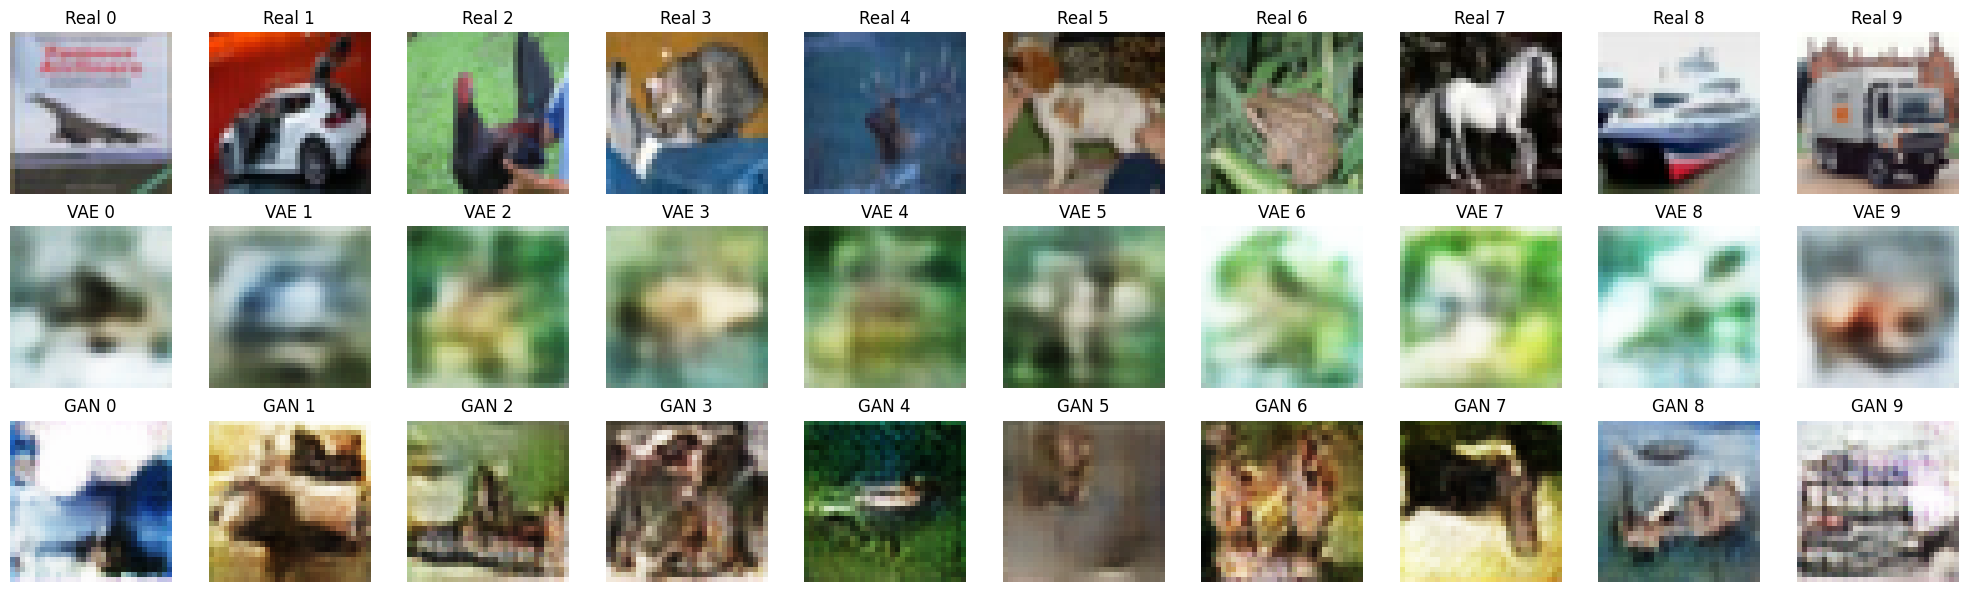

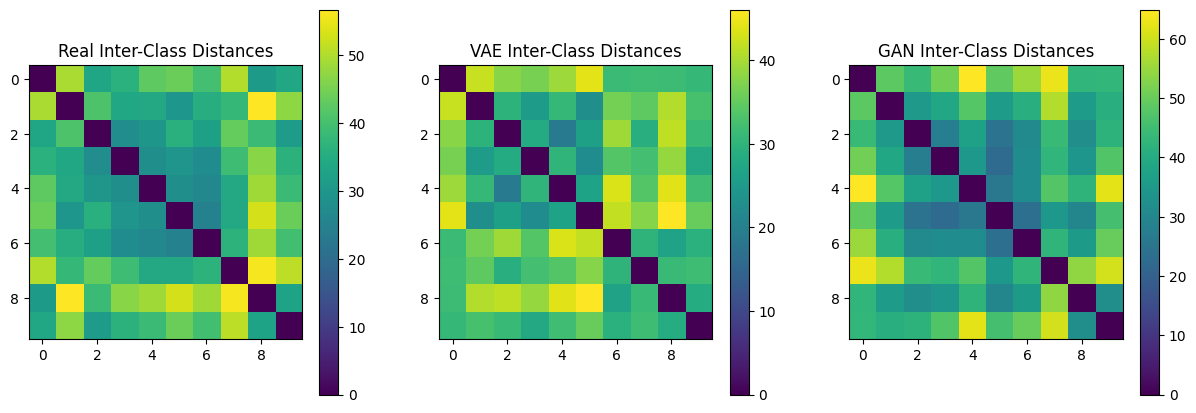

Mean Real inter-class distance: 34.3805
Mean VAE inter-class distance:  29.9207
Mean GAN inter-class distance:  37.2865


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- Pick one VAE sample per class ---
vae_samples = vae_samples.to(device)
vae_chosen = {}
with torch.no_grad():
    preds = classifier1(vae_samples).argmax(dim=1).cpu().numpy()

for i, p in enumerate(preds):
    if p not in vae_chosen:
        vae_chosen[p] = vae_samples[i].cpu()
    if len(vae_chosen) == 10:
        break

# --- Pick one GAN sample per class ---
gan_chosen = {}
with torch.no_grad():
    while len(gan_chosen) < 10:
        z = torch.randn(1, z_dim).to(device)
        fake = testing_gen(z)
        pred = classifier1(fake).argmax(dim=1).item()
        if pred not in gan_chosen:
            gan_chosen[pred] = fake[0].cpu()

# --- Pick one REAL image per class ---
real_chosen = {}
with torch.no_grad():
    for img, lbl in test_loader:
        img, lbl = img.to(device), lbl.to(device)
        for c in range(10):
            if c not in real_chosen and (lbl == c).any():
                real_chosen[c] = img[lbl == c][0].cpu()
        if len(real_chosen) == 10:
            break

# --- Display VAE vs GAN vs Real ---
fig, axes = plt.subplots(3, 10, figsize=(20, 6))
for idx in range(10):
    # Real
    img = real_chosen[idx]
    axes[0, idx].imshow((img.permute(1,2,0) * 0.5 + 0.5).clamp(0,1))
    axes[0, idx].set_title(f"Real {idx}")
    axes[0, idx].axis("off")

    # VAE
    img = vae_chosen[idx]
    axes[1, idx].imshow((img.permute(1,2,0) * 0.5 + 0.5).clamp(0,1))
    axes[1, idx].set_title(f"VAE {idx}")
    axes[1, idx].axis("off")

    # GAN
    img = gan_chosen[idx]
    axes[2, idx].imshow((img.permute(1,2,0) * 0.5 + 0.5).clamp(0,1))
    axes[2, idx].set_title(f"GAN {idx}")
    axes[2, idx].axis("off")

plt.tight_layout()
plt.show()

# --- Compute pairwise Euclidean distances ---
def flatten(img):
    return img.view(-1).numpy()

real_imgs = [real_chosen[c].view(-1) for c in range(10)]
vae_imgs = [vae_chosen[c].view(-1) for c in range(10)]
gan_imgs = [gan_chosen[c].view(-1) for c in range(10)]

def compute_distance_matrix(imgs):
    n = len(imgs)
    dists = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            dists[i,j] = torch.norm(imgs[i] - imgs[j]).item()
    return dists

real_dists = compute_distance_matrix(real_imgs)
vae_dists  = compute_distance_matrix(vae_imgs)
gan_dists  = compute_distance_matrix(gan_imgs)

# --- Plot heatmaps ---
fig, axes = plt.subplots(1, 3, figsize=(15,5))

im0 = axes[0].imshow(real_dists, cmap="viridis")
axes[0].set_title("Real Inter-Class Distances")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(vae_dists, cmap="viridis")
axes[1].set_title("VAE Inter-Class Distances")
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(gan_dists, cmap="viridis")
axes[2].set_title("GAN Inter-Class Distances")
plt.colorbar(im2, ax=axes[2])

plt.show()

# --- Report mean inter-class distance ---
print(f"Mean Real inter-class distance: {real_dists.mean():.4f}")
print(f"Mean VAE inter-class distance:  {vae_dists.mean():.4f}")
print(f"Mean GAN inter-class distance:  {gan_dists.mean():.4f}")


Test results display that GANs, when trained stably display a greater diversity and inception score based on the generations from the vae. This due both in part to the monitored training of the GAN , adjusted to maintain balance in healthy loss regions of the generator and discriminator , which allowed the gan to avoid mode collapse, which occurs in the event of a foolish discriminator or a weak generator, giving the generator less pressure to adapt details to fool the discriminator , and the blurriness of the vae generations. While GAN generations are sharper and more well defined, VAEs tend to produce more blurred outputs as they're trained on a pixelwise loss. As a result, the VAE tends to average , leading to images of seperate classes resembling each other as displayed in the above figure (the FID is impossible though)

The inception score Exp(E(KL(P(Y|X) / P(X)))) , assi

LAtent Space Structure

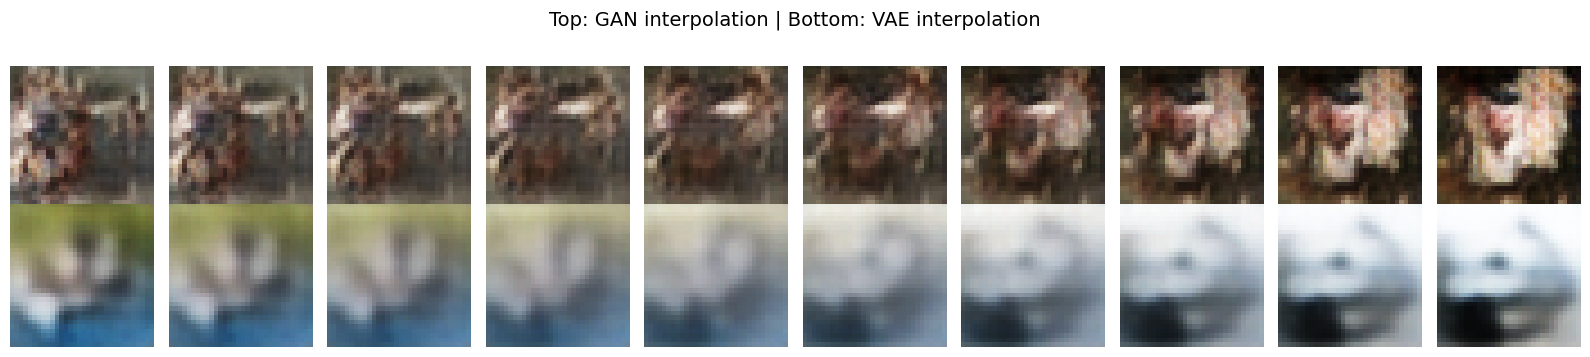

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Params
steps = 10          # number of interpolation frames
z_dim = z_dim       # already defined
device = device     # already defined

# make sure models are on device + eval mode
testing_gen.to(device).eval()
testing_vae.to(device).eval()

# ---- GAN interpolation ----
with torch.no_grad():
    z1 = torch.randn(1, z_dim).to(device)
    z2 = torch.randn(1, z_dim).to(device)

    z_stack = []
    for i in range(steps):
        alpha = i / (steps - 1)
        z_interp = z1 + (z2 - z1) * alpha
        z_stack.append(z_interp)
    z_stack = torch.cat(z_stack, dim=0)   # shape (steps, z_dim)

    gan_imgs = testing_gen(z_stack).cpu()

# ---- VAE interpolation ----
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        if imgs.size(0) >= 2:
            img_a = imgs[0:1]
            img_b = imgs[1:2]
            lbl_a, lbl_b = lbls[0].item(), lbls[1].item()
            break

    _, mu1, _ = testing_vae(img_a)
    _, mu2, _ = testing_vae(img_b)

    z_stack_vae = []
    for i in range(steps):
        alpha = i / (steps - 1)
        z_interp = mu1 + (mu2 - mu1) * alpha
        z_stack_vae.append(z_interp)
    z_stack_vae = torch.cat(z_stack_vae, dim=0)

    vae_imgs = testing_vae.decode(z_stack_vae).cpu()

# ---- Visualization ----
def to_display(img_tensor):
    img = img_tensor.clone()
    if img.min() < -0.1:  # assume [-1,1]
        img = (img + 1) / 2.0
    return img.permute(1,2,0).clamp(0,1).numpy()

fig, axes = plt.subplots(2, steps, figsize=(steps * 1.6, 3.6))
fig.suptitle("Top: GAN interpolation | Bottom: VAE interpolation", fontsize=14)

for i in range(steps):
    axes[0, i].imshow(to_display(gan_imgs[i]))
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_ylabel("GAN", fontsize=10)

    axes[1, i].imshow(to_display(vae_imgs[i]))
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_ylabel(f"VAE\n{lbl_a}->{lbl_b}", fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


The GAN anf thr VAE both display smooth traversals from one point to the other, showing that the GAN can be well behave iif its well trained. there have been instaces displaying explosions or rather minimal changes showing that the GAN's latent isnt very structured and that "anything can happen" interms of shifting values

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.123s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.990139
[t-SNE] KL divergence after 250 iterations with early exaggeration: 110.636742
[t-SNE] KL divergence after 1000 iterations: 2.974823
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.076s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.225789
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.392395
[t-SNE] KL divergence after 1000 iterations: 3.344793


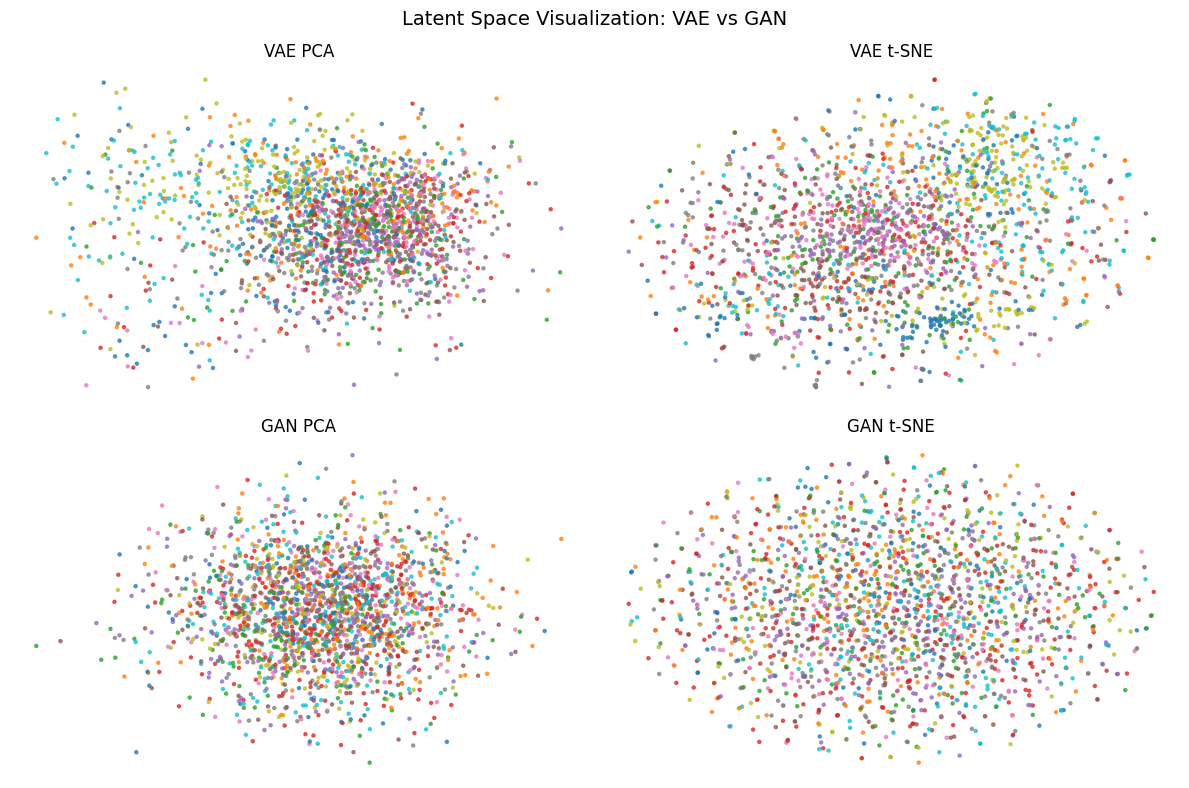

In [ ]:
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --- Parameters ---
limit = 2000   # max samples for each model

# --- Collect VAE latents ---
vae_latents, vae_labels = [], []
testing_vae.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        _, mu, logvar = testing_vae(x)
        vae_latents.append(mu.cpu())
        vae_labels.append(y)
        if sum(len(batch) for batch in vae_labels) >= limit:
            break

vae_latents = torch.cat(vae_latents, dim=0)[:limit]
vae_labels = torch.cat(vae_labels, dim=0)[:limit]

# --- Collect GAN latents and generate samples ---
gan_latents = torch.randn(limit, z_dim).to(device)
testing_gen.eval()
with torch.no_grad():
    gan_samples = testing_gen(gan_latents)

# --- Pass GAN samples through classifier to get predicted labels ---
classifier1.eval()
with torch.no_grad():
    preds = classifier1(gan_samples)
    gan_labels = preds.argmax(dim=1).cpu()  # predicted class indices

gan_latents = gan_latents.cpu()  # move for sklearn

# --- Define dimensionality reducers ---
reducers = {
    "PCA": PCA(n_components=2, random_state=42),
    "t-SNE": TSNE(n_components=2, perplexity=30, learning_rate=200,
                  max_iter=1000, random_state=42, verbose=1)
}

# --- Apply reducers and plot ---
fig, axes = plt.subplots(2, len(reducers), figsize=(12, 8))

for col, (name, reducer) in enumerate(reducers.items()):
    # VAE
    vae_2d = reducer.fit_transform(vae_latents.numpy())
    sc1 = axes[0, col].scatter(
        vae_2d[:, 0], vae_2d[:, 1],
        c=vae_labels.numpy(), cmap="tab10", s=5, alpha=0.7
    )
    axes[0, col].set_title(f"VAE {name}", fontsize=12)
    axes[0, col].axis("off")

    # GAN
    gan_2d = reducer.fit_transform(gan_latents.numpy())
    sc2 = axes[1, col].scatter(
        gan_2d[:, 0], gan_2d[:, 1],
        c=gan_labels.numpy(), cmap="tab10", s=5, alpha=0.7
    )
    axes[1, col].set_title(f"GAN {name}", fontsize=12)
    axes[1, col].axis("off")

fig.suptitle("Latent Space Visualization: VAE vs GAN", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
VAE PCA: The latent distribution resembles a Gaussian but with a shifted mean and a different standard deviation. There is a subtle class-wise bias in the latent space—for instance, points in the far-left region along the x-axis are predominantly from one class (e.g., blue points), while other classes are clustered closer to the mean. This indicates that most of the data and variance lie near the center. Although there isn’t strong, perfectly separated class-wise clustering, we can still observe small groupings of points, suggesting some degree of disentanglement. Altering certain latent features appears to influence class-specific characteristics.

VAE t-SNE: The t-SNE projection further reveals local structures. Data points belonging to the same class tend to form small clusters, implying that the model captures subtle class-specific features even in high-dimensional space.

GAN PCA and t-SNE: In contrast, the GAN latent space appears as an unstructured Gaussian blob. There is no meaningful clustering or class-wise organization, and the distribution reflects the prior rather than any learned structure. As a result, there is little coherence or interpretable variation in the latent representations.

Summary: The VAE latent space demonstrates structured representations with some class-specific bias and disentanglement, whereas the GAN latent space largely reflects the random prior without meaningful class separation.

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# --- Parameters ---
batch_size = 32
num_workers = 2  # adjust depending on your system
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Define CIFAR-style transforms for SVHN ---
svhn_transform = transforms.Compose([
    transforms.Resize((32, 32)),                     # Resize to 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# --- Load SVHN test dataset ---
svhn_test = datasets.SVHN(
    root="./data",          # path to store/download SVHN
    split="test",           # "train" or "test"
    download=True,
    transform=svhn_transform
)

# --- Define DataLoader ---
svhn_loader = DataLoader(
    svhn_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

# --- Optional: Check one batch ---
images, labels = next(iter(svhn_loader))
print("Batch shape:", images.shape)
print("Labels:", labels)


100%|██████████| 64.3M/64.3M [00:02<00:00, 21.5MB/s]


Batch shape: torch.Size([32, 3, 32, 32])
Labels: tensor([5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, 4, 1, 6, 3, 4, 2, 0, 1, 3,
        2, 5, 4, 1, 4, 2, 8, 3])


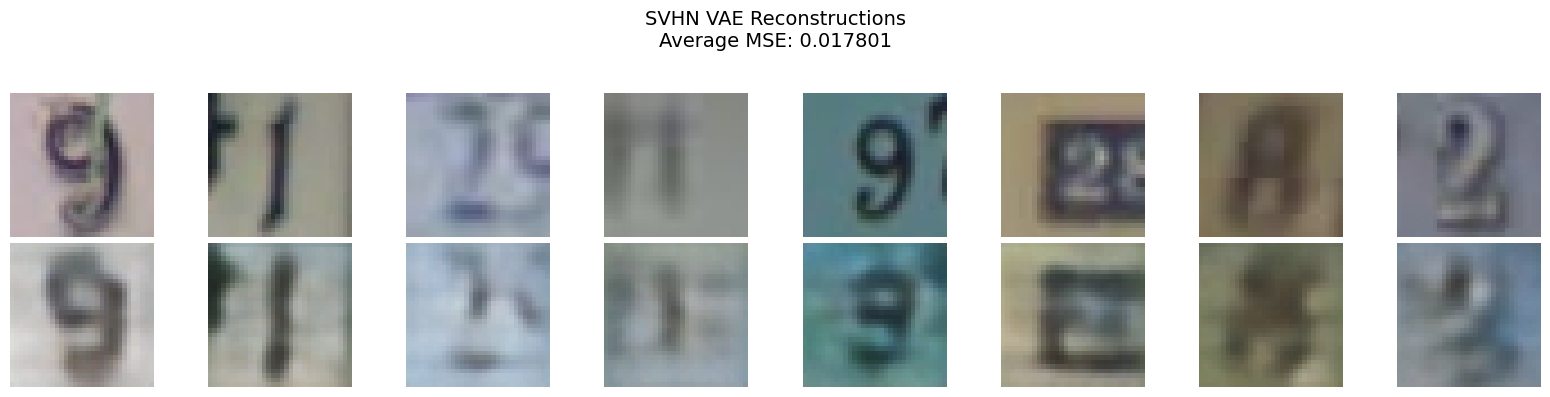

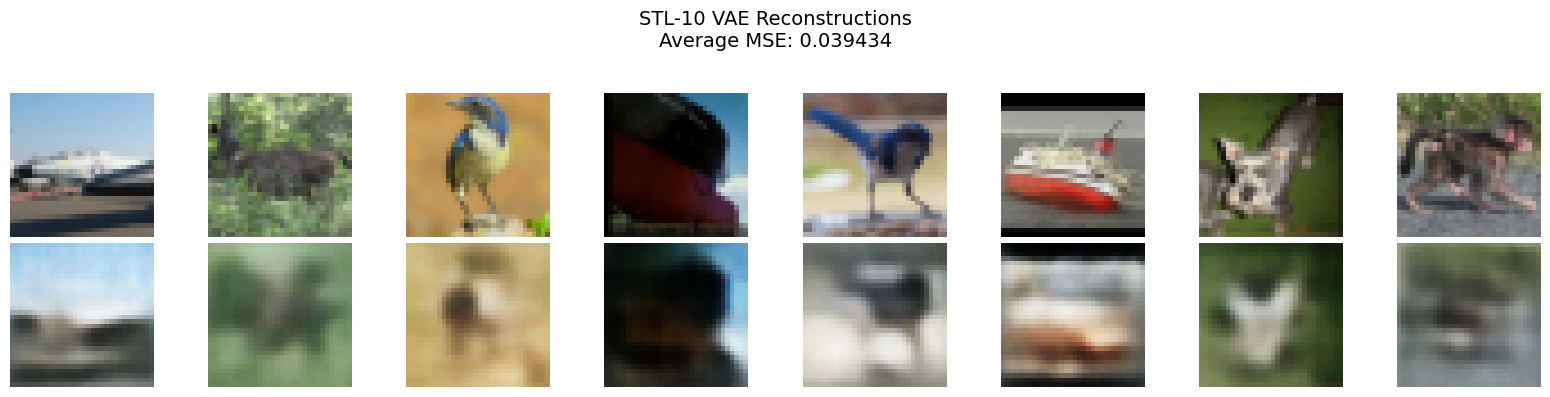

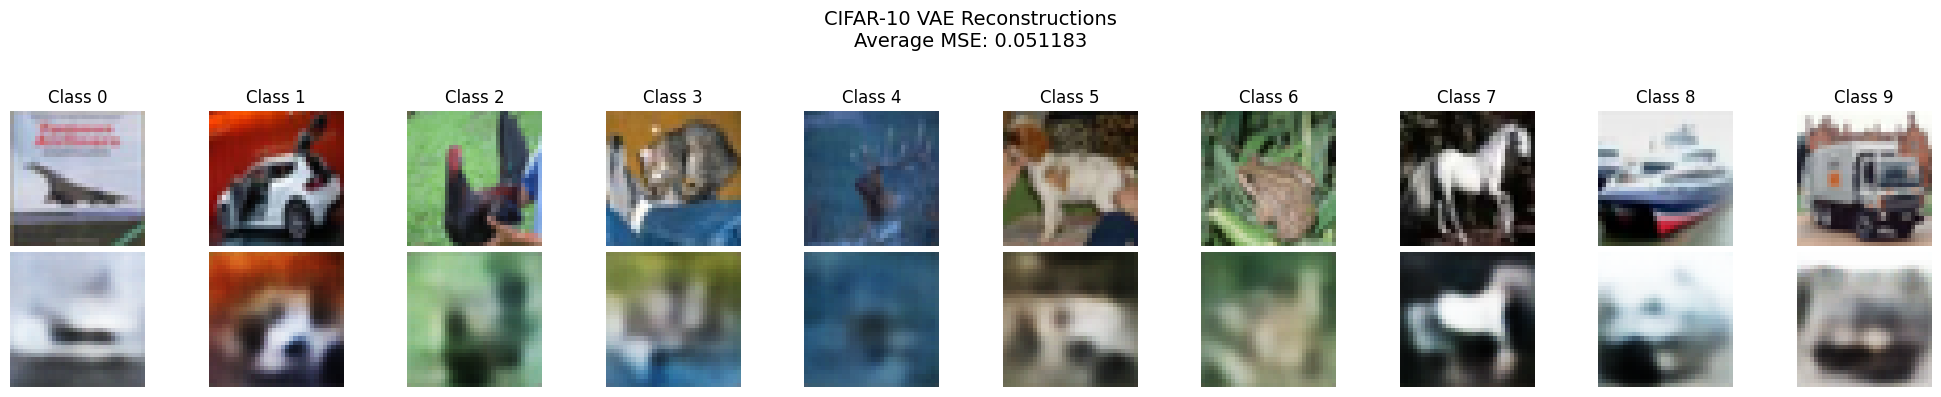

FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM

but Gdown can't. Please check connections and permissions.

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = 'cuda'  # or 'cpu'
num_samples = 8  # number of images to visualize

# --- Helper to unnormalize images ---
def unnormalize(tensor):
    return (tensor * 0.5 + 0.5).clamp(0, 1)

# --- Function to visualize reconstructions and compute average MSE ---
def visualize_reconstructions(dataset_name, dataloader, transform_for_display=None):
    testing_vae.eval()
    inputs, recons = [], []
    count = 0

    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            recon, _, _ = testing_vae(x)
            inputs.append(x.cpu())
            recons.append(recon.cpu())
            count += x.size(0)
            if count >= num_samples:
                break

    inputs = torch.cat(inputs)[:num_samples]
    recons = torch.cat(recons)[:num_samples]

    # Calculate average MSE
    mse = F.mse_loss(recons, inputs).item()

    # Plot images
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))
    for i in range(num_samples):
        # Original
        img = inputs[i]
        if transform_for_display is not None:
            img = transform_for_display(img)
        else:
            img = unnormalize(img)
        axes[0, i].imshow(img.permute(1, 2, 0))
        axes[0, i].axis("off")

        # Reconstruction
        rec_img = recons[i]
        if transform_for_display is not None:
            rec_img = transform_for_display(rec_img)
        else:
            rec_img = unnormalize(rec_img)
        axes[1, i].imshow(rec_img.permute(1, 2, 0))
        axes[1, i].axis("off")

    axes[0, 0].set_ylabel("Original", fontsize=12)
    axes[1, 0].set_ylabel("Reconstruction", fontsize=12)
    plt.suptitle(f"{dataset_name} VAE Reconstructions\nAverage MSE: {mse:.6f}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# --- SVHN Dataset ---
svhn_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
svhn_dataset = datasets.SVHN(root="./data", split="test", download=True, transform=svhn_transform)
svhn_loader = DataLoader(svhn_dataset, batch_size=64, shuffle=True)

visualize_reconstructions("SVHN", svhn_loader)


# --- STL-10 Dataset ---
stl10_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
stl10_dataset = datasets.STL10(root="./data", split="test", download=True, transform=stl10_transform)
stl10_loader = DataLoader(stl10_dataset, batch_size=64, shuffle=True)

visualize_reconstructions("STL-10", stl10_loader)


import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = 'cuda'  # or 'cpu'
num_classes = 10

# --- Helper to unnormalize images ---
def unnormalize(tensor):
    return (tensor * 0.5 + 0.5).clamp(0, 1)

# --- Function to visualize one reconstruction per class ---
def visualize_cifar10_reconstructions(test_loader):
    testing_vae.eval()
    inputs_per_class = [None] * num_classes
    recons_per_class = [None] * num_classes

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            recon, _, _ = testing_vae(x)

            for i in range(x.size(0)):
                c = y[i].item()
                if inputs_per_class[c] is None:
                    inputs_per_class[c] = x[i].cpu()
                    recons_per_class[c] = recon[i].cpu()
            if all(v is not None for v in inputs_per_class):
                break

    # Calculate average MSE across collected samples
    inputs_tensor = torch.stack(inputs_per_class)
    recons_tensor = torch.stack(recons_per_class)
    mse = F.mse_loss(recons_tensor, inputs_tensor).item()

    # Plot images: original and reconstructions
    fig, axes = plt.subplots(2, num_classes, figsize=(num_classes * 2, 4))
    for i in range(num_classes):
        img = unnormalize(inputs_per_class[i])
        rec_img = unnormalize(recons_per_class[i])

        axes[0, i].imshow(img.permute(1, 2, 0))
        axes[0, i].axis("off")
        axes[0, i].set_title(f"Class {i}")

        axes[1, i].imshow(rec_img.permute(1, 2, 0))
        axes[1, i].axis("off")

    axes[0, 0].set_ylabel("Original", fontsize=12)
    axes[1, 0].set_ylabel("Reconstruction", fontsize=12)
    plt.suptitle(f"CIFAR-10 VAE Reconstructions\nAverage MSE: {mse:.6f}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Call with your preloaded CIFAR-10 test_loader
visualize_cifar10_reconstructions(test_loader)



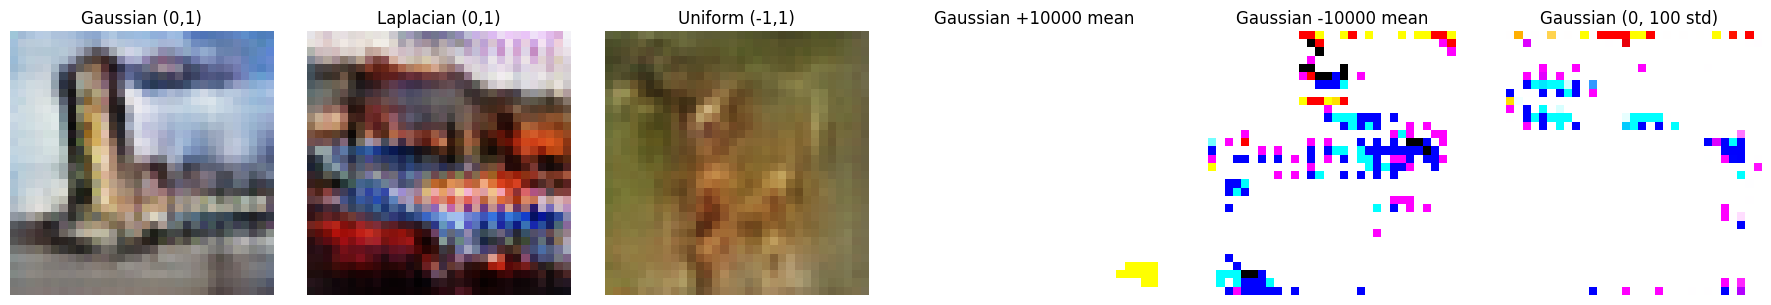

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda'  # adjust if needed
z_dim = 64       # your latent dim, adjust if needed

# Define one latent vector per distribution
z_sets = {
    "Gaussian (0,1)": torch.randn(1, z_dim),
    "Laplacian (0,1)": torch.from_numpy(np.random.laplace(0, 1, (1, z_dim))).float(),
    "Uniform (-1,1)": torch.from_numpy(np.random.uniform(-1, 1, (1, z_dim))).float(),
    "Gaussian +10000 mean": torch.randn(1, z_dim) + 10000,
    "Gaussian -10000 mean": torch.randn(1, z_dim) - 10000,
    "Gaussian (0, 100 std)": torch.randn(1, z_dim) * 100,
}

# Move to device
for key in z_sets:
    z_sets[key] = z_sets[key].to(device)

with torch.no_grad():
    fig, axes = plt.subplots(1, len(z_sets), figsize=(18, 3))
    for i, (key, z) in enumerate(z_sets.items()):
        gan_sample = testing_gen(z)[0].cpu()
        img = (gan_sample.permute(1, 2, 0) * 0.5 + 0.5).clamp(0, 1)  # Normalize for display
        axes[i].imshow(img)
        axes[i].set_title(key)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


This inherent ability to reconstruct well is invversely proportional to the value of beta
Our ELBO loss has 2 components, recon and KL loss, wit the former prioritizing lowering mse betwwn input and output and the latter focusinging on closing the distance between the posterior q(z|x) and the prior p(z). Because of this, inherently, our VAEs actually generalizes better with smaller betas

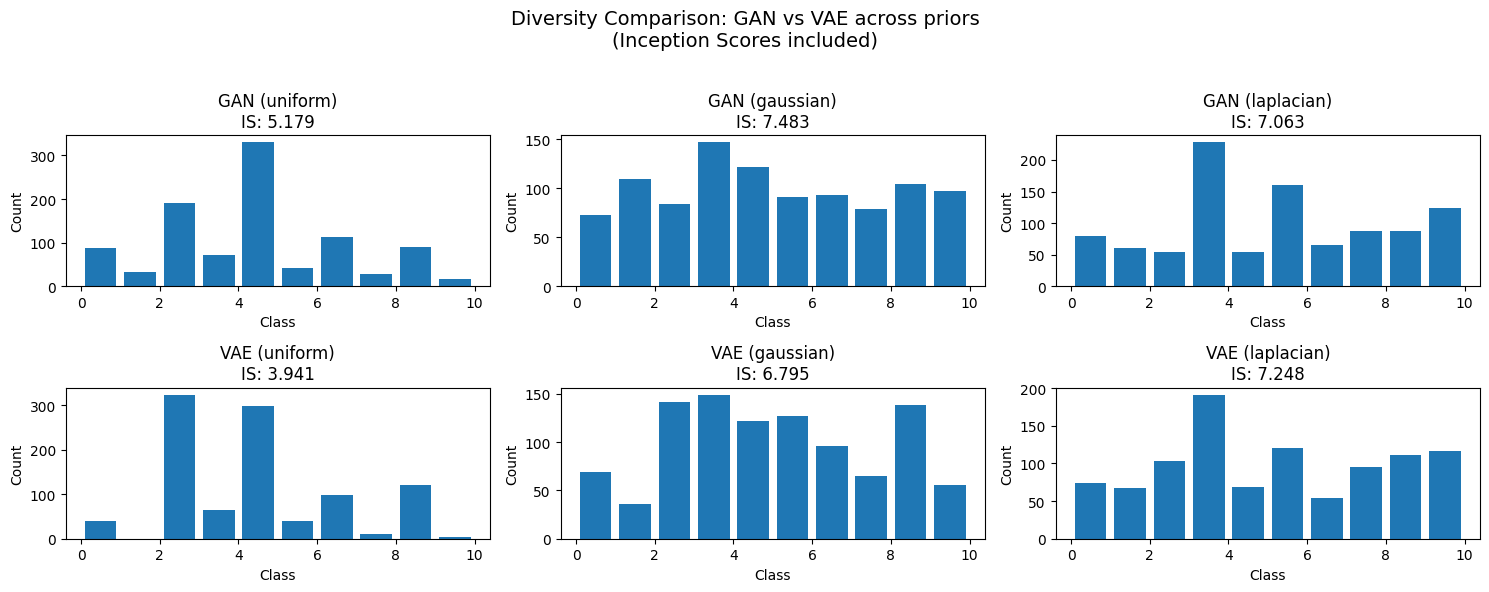

Inception Scores by Model and Distribution:
GAN (uniform): 5.1789
GAN (gaussian): 7.4831
GAN (laplacian): 7.0629
VAE (uniform): 3.9415
VAE (gaussian): 6.7951
VAE (laplacian): 7.2476


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

n_samples = 1000
distributions = ["uniform", "gaussian", "laplacian"]

results = {"GAN": {}, "VAE": {}}
images_for_is = {"GAN": {}, "VAE": {}}  # Store generated images for IS

with torch.no_grad():
    for dist in distributions:
        # --- Sample latent z ---
        if dist == "uniform":
            z_np = np.random.uniform(-1, 1, (n_samples, z_dim))
        elif dist == "gaussian":
            z_np = np.random.normal(0, 1, (n_samples, z_dim))
        elif dist == "laplacian":
            z_np = np.random.laplace(0, 1, (n_samples, z_dim))
        else:
            raise ValueError("Unknown distribution")

        z = torch.from_numpy(z_np).float().to(device)

        # --- GAN samples ---
        gan_samples = testing_gen(z)
        gan_out = classifier1(gan_samples)
        results["GAN"][dist] = gan_out.argmax(dim=1).cpu().numpy()
        images_for_is["GAN"][dist] = gan_samples.cpu()

        # --- VAE samples ---
        vae_samples = testing_vae.decode(z)
        vae_out = classifier1(vae_samples)
        results["VAE"][dist] = vae_out.argmax(dim=1).cpu().numpy()
        images_for_is["VAE"][dist] = vae_samples.cpu()

# --- Compute Inception Scores using your predefined function ---
inception_scores = {"GAN": {}, "VAE": {}}
for model in ["GAN", "VAE"]:
    for dist in distributions:
        imgs = images_for_is[model][dist].to(device)
        score = compute_inception_score(classifier1, imgs, device=device)
        inception_scores[model][dist] = score

# ---- Plot histograms ----
fig, axes = plt.subplots(2, len(distributions), figsize=(15, 6))
fig.suptitle("Diversity Comparison: GAN vs VAE across priors\n(Inception Scores included)", fontsize=14)

for i, dist in enumerate(distributions):
    # GAN row
    axes[0, i].hist(results["GAN"][dist], bins=range(11), rwidth=0.8)
    axes[0, i].set_title(f"GAN ({dist})\nIS: {inception_scores['GAN'][dist]:.3f}")
    axes[0, i].set_xlabel("Class")
    axes[0, i].set_ylabel("Count")

    # VAE row
    axes[1, i].hist(results["VAE"][dist], bins=range(11), rwidth=0.8)
    axes[1, i].set_title(f"VAE ({dist})\nIS: {inception_scores['VAE'][dist]:.3f}")
    axes[1, i].set_xlabel("Class")
    axes[1, i].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Optional: print Inception Scores ---
print("Inception Scores by Model and Distribution:")
for model in ["GAN", "VAE"]:
    for dist in distributions:
        print(f"{model} ({dist}): {inception_scores[model][dist]:.4f}")


Training (VAEs):The VAE model was trained on CIFAR-10, using normalization with a mean of 0.5 and the same standard deviation across all three channels. The model architecture is provided in the GitHub repository.

Training the VAE was relatively straightforward, with the primary hyperparameter of influence being the β coefficient. The training schedule employed a β-annealing strategy, where β was gradually increased from 0 to 0.01 over the course of training. This allowed the model to first focus on capturing reconstruction quality before progressively learning to align the approximate posterior with the prior distribution.

A set of experiments was conducted with five configurations:

β = 0 (no regularization)

β = 0.01

β = 0.1

β = 1.0

β-annealing from 0 to 0.01

All models were trained for 25 epochs under identical conditions. The results showed that increasing β led to greater latent disentanglement, consistent with prior findings, while lower β values yielded sharper reconstructions and stronger generalization on out-of-distribution (OOD) inputs.

A key consideration during training was the risk of posterior collapse, but this was not observed, likely due to the relatively small β values employed. The final model selected for testing was trained for 70 epochs with β-annealing.

Training(GANS): Training the GAN was more challenging compared to the VAE, owing to the adversarial nature of its optimization. Both the generator and discriminator were trained on CIFAR-10, using normalization with mean and standard deviation values of (0.5, 0.5, 0.5). The models were initialized with identical learning rates, and no momentum terms (β values) were used. Both networks were updated an equal number of times in each epoch.

The GAN was trained for 30 epochs under these conditions. During this stage, the generator began to outperform the discriminator, at which point its learning rate was reduced by a factor of 1.5. This adjustment restored balance between the two networks, and equilibrium was maintained for approximately 10 additional epochs before training was terminated.

Label smoothing was employed in the discriminator to stabilize training. Instead of the conventional smoothing factor of 0.9, a milder factor of 0.96 was used. This design choice prevented the discriminator from becoming overly confident, promoted faster convergence, and mitigated cases where the generator could quickly overpower the discriminator.

The primary concern during training was mode collapse, which can occur when either the generator dominates the discriminator or vice versa. To mitigate this, training was closely monitored. Rather than following a single fixed training schedule, optimizers with adjusted learning rates were alternated whenever equilibrium was disrupted. This adaptive approach consistently forced the two models back into balance.

As a result, the trained GAN achieved strong performance, producing samples with high diversity, high fidelity, and accurate class representation, while exhibiting fewer artifacts during transitions.

In [ ]:
Training Losses

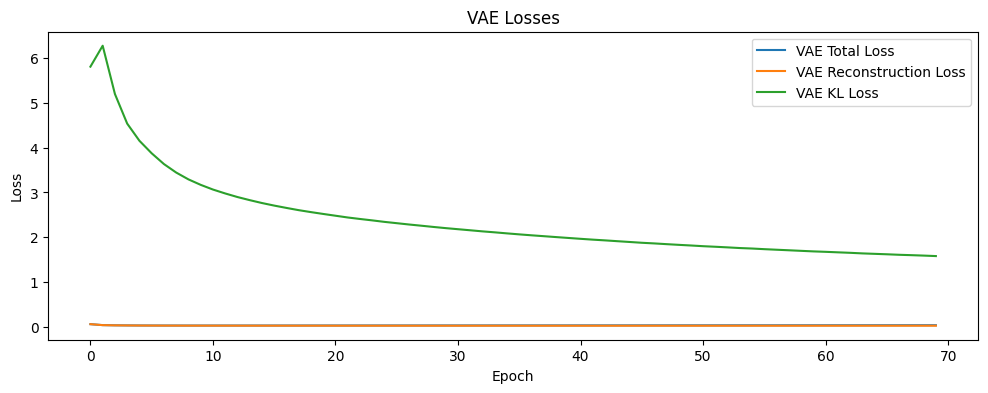

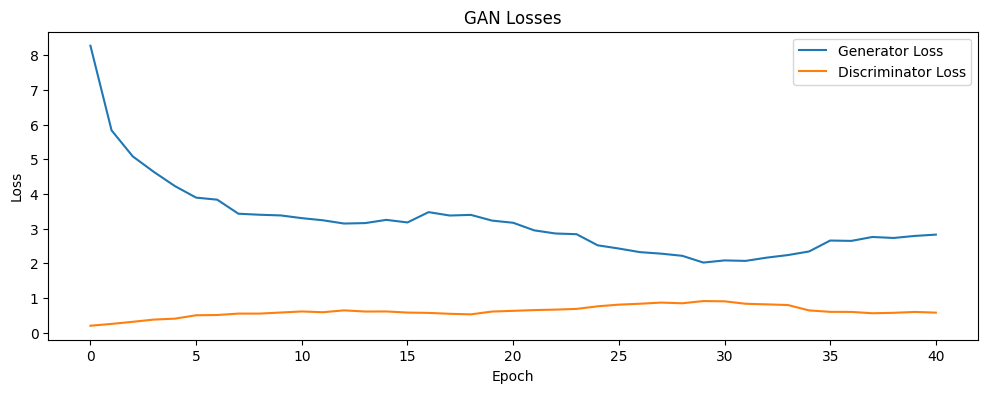

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
vae_csv_path = "drive/MyDrive/Assignment_1/vae1_losses.csv"
gen_csv_path = "drive/MyDrive/Assignment_1/losses_gen (1).csv"
disc_csv_path = "drive/MyDrive/Assignment_1/losses_disc (1).csv"

# Load CSVs
vae_df = pd.read_csv(vae_csv_path)
gen_df = pd.read_csv(gen_csv_path)
disc_df = pd.read_csv(disc_csv_path)

# Extract columns by position using iloc
vae_total = vae_df.iloc[:, 1].tolist()  # 1st column: total loss
vae_recon = vae_df.iloc[:, 2].tolist()  # 2nd column: recon loss
vae_kl = vae_df.iloc[:, 3].tolist()     # 3rd column: kl loss

gen_loss = gen_df.iloc[:, 0].tolist()   # 1st column: generator loss
disc_loss = disc_df.iloc[:, 0].tolist() # 1st column: discriminator loss

# Plot VAE losses
plt.figure(figsize=(12, 4))
plt.plot(vae_total, label='VAE Total Loss')
plt.plot(vae_recon, label='VAE Reconstruction Loss')
plt.plot(vae_kl, label='VAE KL Loss')
plt.title('VAE Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Generator and Discriminator losses
plt.figure(figsize=(12, 4))
plt.plot(gen_loss, label='Generator Loss')
plt.plot(disc_loss, label='Discriminator Loss')
plt.title('GAN Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


/tmp/ipython-input-1427831368.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(x_labels, rotation=90)
/tmp/ipython-input-1427831368.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(x_labels, rotation=90)


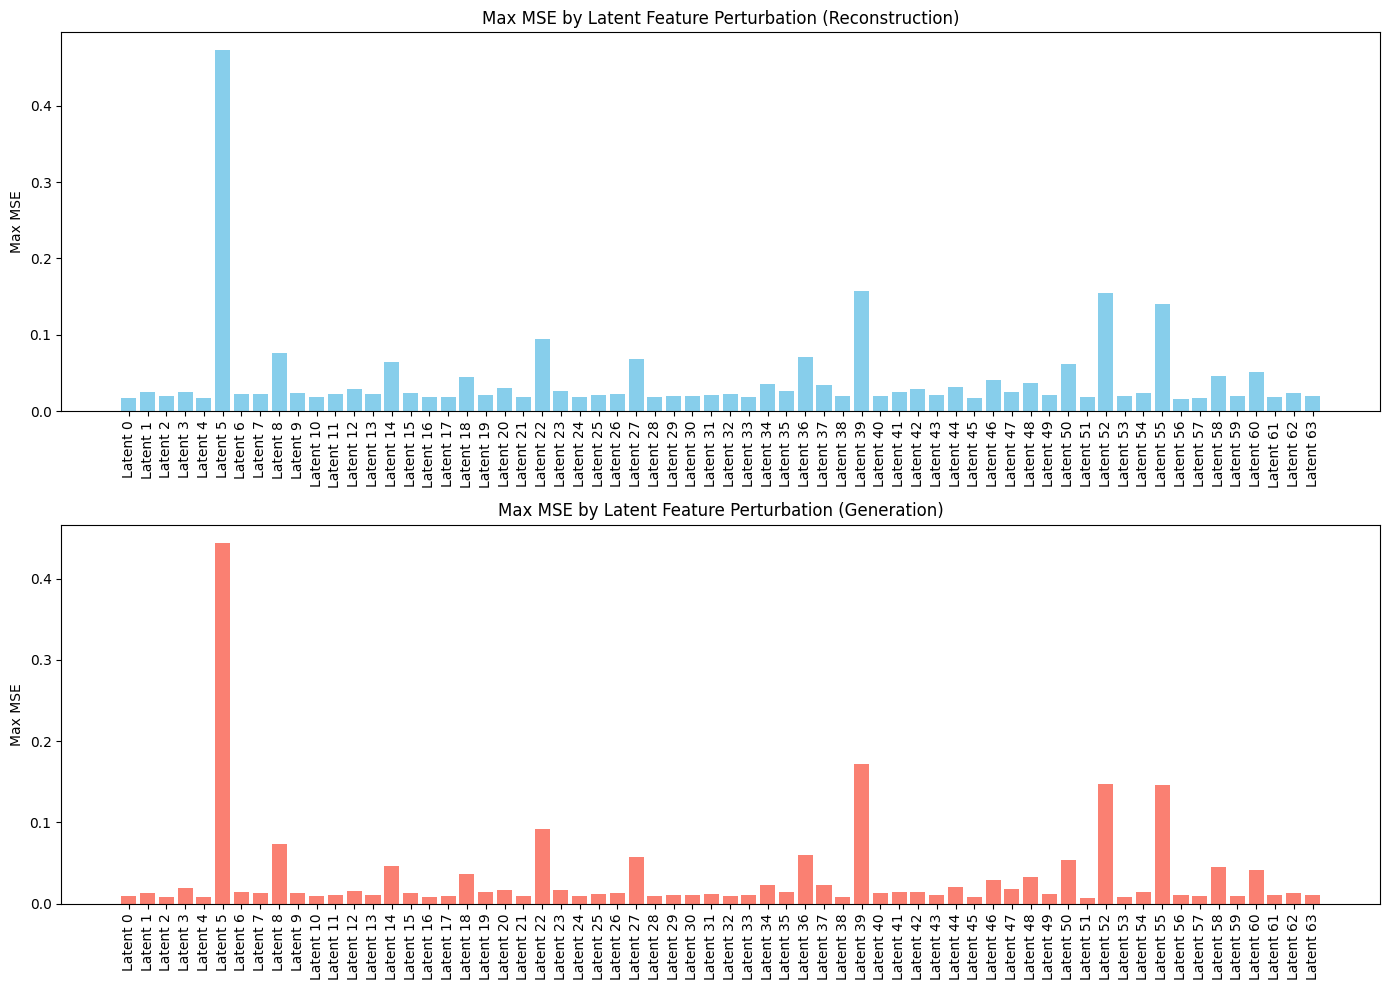

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

vae.eval()
x, _ = next(iter(test_loader))
x = x[:1].to(device)

with torch.no_grad():
    recon, mu, logvar = vae(x)
    z = vae.reparameterize(mu, logvar)

# Generate from prior
z_prior = torch.randn_like(z).to(device)
gen = vae.decode(z_prior)

# Perturbations setup
alphas = torch.linspace(-3, 3, 8).to(device)
n_latents = z.shape[1]

# Store MSE for each latent dimension and alpha perturbation
mse_recon_perturb = torch.zeros((n_latents, len(alphas)))
mse_gen_perturb = torch.zeros((n_latents, len(alphas)))

with torch.no_grad():
    for i in range(n_latents):
        for j, alpha in enumerate(alphas):
            # Perturb reconstruction latent
            z_perturbed = z.clone()
            z_perturbed[0, i] += alpha
            x_dec_recon = vae.decode(z_perturbed)
            mse_recon_perturb[i, j] = F.mse_loss(x_dec_recon, recon).item()

            # Perturb prior latent
            z_prior_perturbed = z_prior.clone()
            z_prior_perturbed[0, i] += alpha
            x_dec_gen = vae.decode(z_prior_perturbed)
            mse_gen_perturb[i, j] = F.mse_loss(x_dec_gen, gen).item()

# Aggregate MSE per latent dim (choose max or mean)
max_mse_recon = mse_recon_perturb.max(dim=1).values.cpu()
max_mse_gen = mse_gen_perturb.max(dim=1).values.cpu()

# Plot bar charts
fig, axs = plt.subplots(2, 1, figsize=(14, 10))

x_labels = [f"Latent {i}" for i in range(n_latents)]

axs[0].bar(x_labels, max_mse_recon, color='skyblue')
axs[0].set_title('Max MSE by Latent Feature Perturbation (Reconstruction)')
axs[0].set_ylabel('Max MSE')
axs[0].set_xticklabels(x_labels, rotation=90)

axs[1].bar(x_labels, max_mse_gen, color='salmon')
axs[1].set_title('Max MSE by Latent Feature Perturbation (Generation)')
axs[1].set_ylabel('Max MSE')
axs[1].set_xticklabels(x_labels, rotation=90)

plt.tight_layout()
plt.show()


In [ ]:
checkpoint = torch.load(path, map_location="cpu")
print(type(checkpoint))
print(checkpoint.keys())  # top-level keys


<class 'dict'>
dict_keys(['vae1', 'vae2', 'vae3', 'vae4', 'vae5', 'opt1', 'opt2', 'opt3', 'opt4', 'opt5'])


In [ ]:
import torch

path = "drive/MyDrive/Assignment_1/vae_multi_beta_checkpoint.pth"
checkpoint = torch.load(path, map_location="cuda")  # or "cpu"

# --- Your VAE class should be defined above this ---
vae_list = []
for i in range(1, 6):  # vae1 ... vae5
    key = f"vae{i}"
    vae = VAE_b(64).to("cuda")  # adjust args if needed
    vae.load_state_dict(checkpoint[key])  # load only model dicts
    vae.eval()
    vae_list.append(vae)

print(f"Loaded {len(vae_list)} VAEs into vae_list ✅")


Loaded 5 VAEs into vae_list ✅



=== $\beta = 0$ ===

=== $\beta = 0.001$ ===

=== $\beta = 0.01$ ===

=== $\beta = 0.1$ ===

=== $\beta$ annealing ===


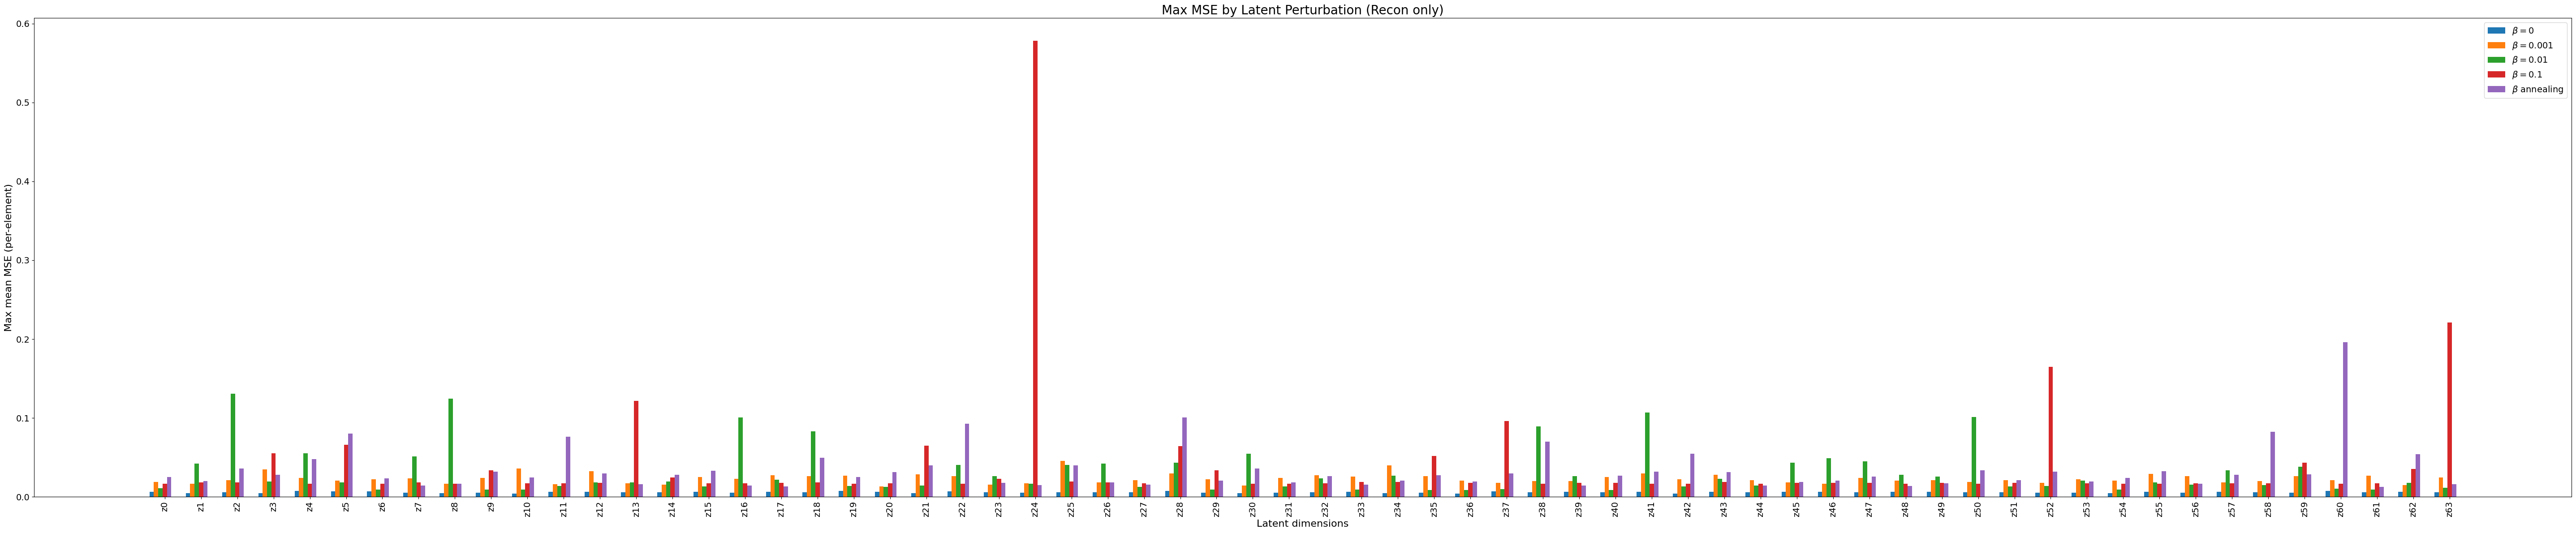

In [ ]:
# --- Define labels for VAEs based on beta values ---
vae_labels = [
    r"$\beta = 0$",
    r"$\beta = 0.001$",
    r"$\beta = 0.01$",
    r"$\beta = 0.1$",
    r"$\beta$ annealing"
]

# --- Run perturbation for all VAEs and collect recon-only MSEs ---
all_recon_mse = []
for idx, vae in enumerate(vae_list, 1):
    print(f"\n=== {vae_labels[idx-1]} ===")
    vae.to(device)

    max_mse_recon, _, _, _, _ = perturbation_analysis(vae, test_loader, device)
    all_recon_mse.append(max_mse_recon)

# --- Plot all VAEs on the same axes ---
latent_count = len(all_recon_mse[0])
x = np.arange(latent_count)

# Bigger figure (width grows with latent count, height also increased)
fig, ax = plt.subplots(figsize=(max(20, latent_count * 0.9), 12))
width = 0.12  # narrower bars for clarity when many VAEs

for idx, mse_vals in enumerate(all_recon_mse):
    ax.bar(x + (idx - (len(all_recon_mse)+1)/2) * width,
           mse_vals, width, label=vae_labels[idx])

ax.set_title('Max MSE by Latent Perturbation (Recon only)', fontsize=20)
ax.set_ylabel('Max mean MSE (per-element)', fontsize=16)
ax.set_xlabel('Latent dimensions', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels([f"z{i}" for i in range(latent_count)], rotation=90, fontsize=14)
ax.legend(fontsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.show()
